# GSVA 联合 IC50 进行耐药性分析

使用CCLE中的细胞系，在DepMap上已公开的数据集

分析思路：

+ 获取细胞系的IC50值

+ 获取对应细胞系基因表达结果

+ 提取细胞系：基因表达值，IC50值

+ 基于基因表达进行GSVA分析，获取GSVA score值

+ 分析GSVA score值与IC50值得关系，选择highly correlated pathways

    - negative related
    - positive related

## 下载数据

从depmap上，自定义下载数据： https://depmap.org/portal/download/custom/

<img src="./figures/figure1.jpg" >

从Depmap上下载的数据和GDSC官网下载的数据不一样呢？？！

+ Expression_22Q1_Public

+ Mutation_22Q1_Public

+ Drug_sensitivity_IC50_(Sanger_GDSC1)

+ Drug_sensitivity_IC50_(Sanger_GDSC2)

### Drug response数据


+ 单个药物进行下载

https://www.cancerrxgene.org/compound/Ibrutinib/1799/overview/ic50

Ibrutinib只在GDSC2数据集中有数据

+ download reource

https://www.cancerrxgene.org/downloads/bulk_download

<img src="./figures/figure2.jpg">

+ GDSC1_fitted_dose_response_25Feb20
+ GDSC2_fitted_dose_response_25Feb20

#### IC50分布

In [7]:
GDSC1_dose_response=readxl::read_xlsx("GDSC1_fitted_dose_response_25Feb20.xlsx")
head(GDSC1_dose_response)

DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,2.395685,0.982114,0.022521,-0.189576
GDSC1,281,12975300,684055,ES3,SIDM00265,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,3.140923,0.984816,0.031840,0.508635
GDSC1,281,12975647,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,3.968757,0.985693,0.026052,1.284229
GDSC1,281,12975980,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,2.692768,0.972699,0.110056,0.088760
GDSC1,281,12976330,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,2.478678,0.944462,0.087011,-0.111820
GDSC1,281,12976635,684072,SK-ES-1,SIDM01111,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,2.034050,0.950763,0.016288,-0.528390


In [13]:
GDSC2_dose_response=readxl::read_xlsx("GDSC2_fitted_dose_response_25Feb20.xlsx")
head(GDSC2_dose_response)

DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GDSC2,282,13320532,749709,HCC1954,SIDM00872,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,9.8e-05,0.1,-0.251083,0.975203,0.112373,0.906631
GDSC2,282,13320565,749710,HCC1143,SIDM00866,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,9.8e-05,0.1,1.343315,0.978464,0.067577,1.683567
GDSC2,282,13320598,749711,HCC1187,SIDM00885,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,9.8e-05,0.1,1.736985,0.995100,0.045205,1.875399
GDSC2,282,13320631,749712,HCC1395,SIDM00884,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,9.8e-05,0.1,-2.309078,0.867832,0.107282,-0.096212
GDSC2,282,13320668,749713,HCC1599,SIDM00877,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,9.8e-05,0.1,-3.106684,0.777532,0.098286,-0.484878
GDSC2,282,13320711,749714,HCC1937,SIDM00874,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,9.8e-05,0.1,0.224916,0.964637,0.065601,1.138581


IC50分布，AUC分布

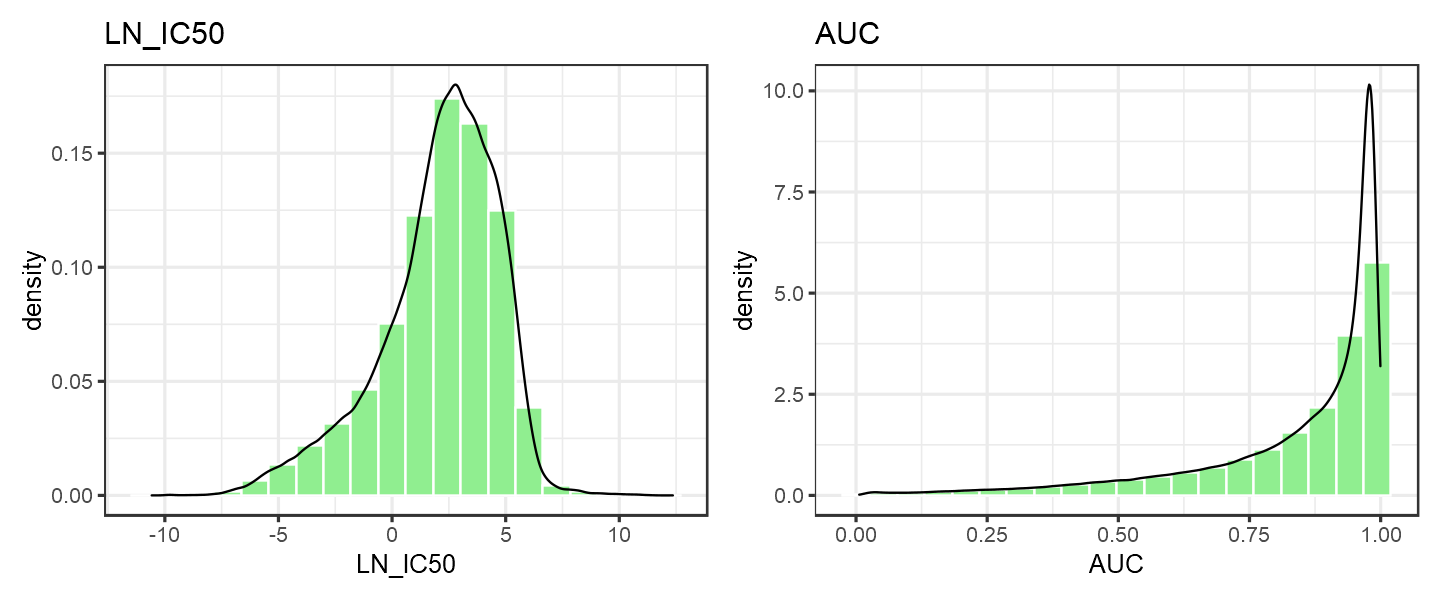

In [11]:
options(repr.plot.width=12, repr.plot.height=5)
p1=GDSC1_dose_response %>% arrange(desc(LN_IC50)) %>% 
  ggplot(aes(x=LN_IC50))+
  geom_histogram(aes(y=..density..),
                 bins=20,
                 color='white',fill="lightgreen")+
  geom_density() + ggtitle("LN_IC50")+
  theme_bw(base_size = 15)

p2=GDSC1_dose_response %>% arrange(desc(AUC)) %>% 
  ggplot(aes(x=AUC))+
  geom_histogram(aes(y=..density..),
                 bins=20,
                 color='white',fill="lightgreen")+
  geom_density() + ggtitle("AUC")+
  theme_bw(base_size = 15)

p1|p2

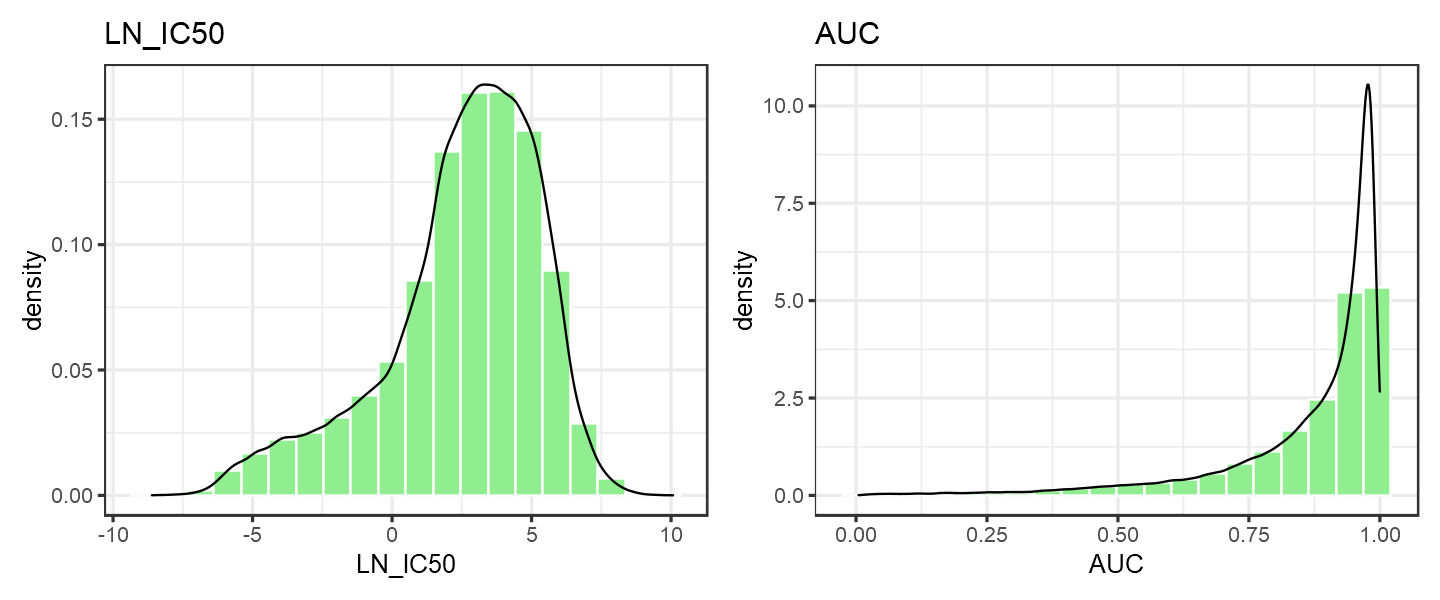

In [12]:
options(repr.plot.width=12, repr.plot.height=5)
p1=GDSC2_dose_response %>% arrange(desc(LN_IC50)) %>% 
  ggplot(aes(x=LN_IC50))+
  geom_histogram(aes(y=..density..),
                 bins=20,
                 color='white',fill="lightgreen")+
  geom_density() + ggtitle("LN_IC50")+
  theme_bw(base_size = 15)

p2=GDSC2_dose_response %>% arrange(desc(AUC)) %>% 
  ggplot(aes(x=AUC))+
  geom_histogram(aes(y=..density..),
                 bins=20,
                 color='white',fill="lightgreen")+
  geom_density() + ggtitle("AUC")+
  theme_bw(base_size = 15)

p1|p2

#### 药物分布

In [21]:
as.data.frame(table(c(GDSC1_dose_response$DRUG_NAME,GDSC2_dose_response$DRUG_NAME))) %>% arrange(desc(Freq)) %>% head()

,Var1,Freq
,<fct>,<int>
1,PLX-4720,2666
2,Afatinib,2662
3,Cisplatin,2647
4,AZD7762,2642
5,Olaparib,2614
6,Pictilisib,2581


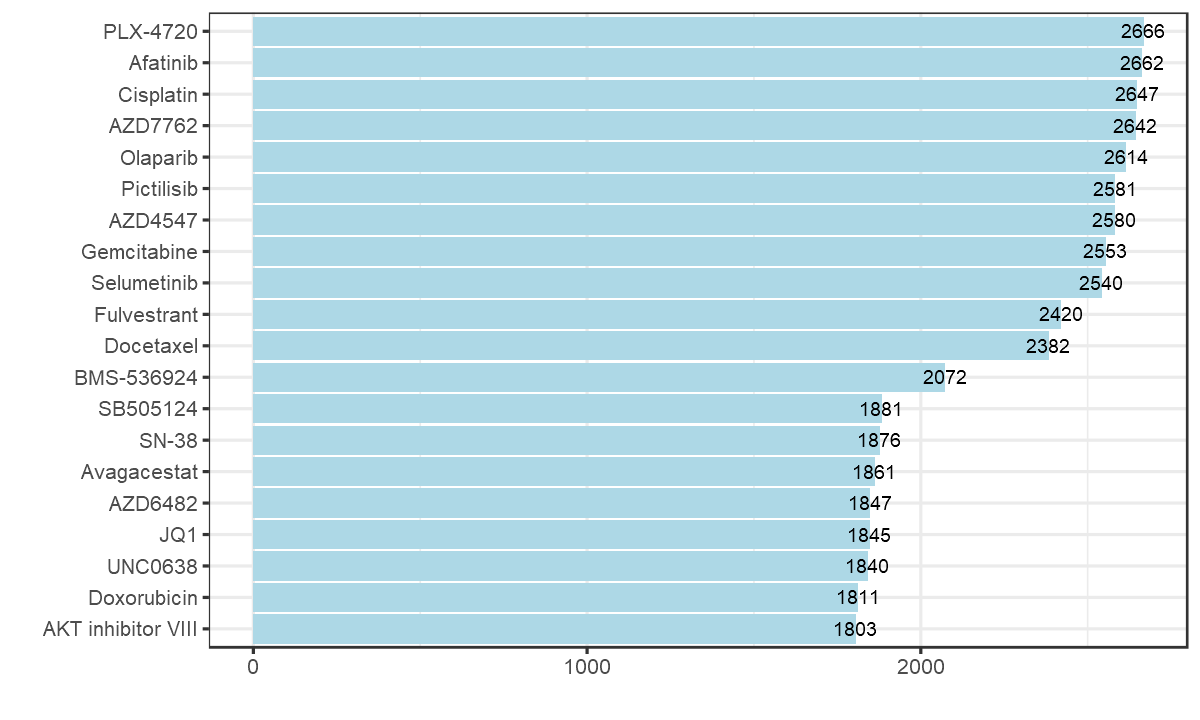

In [176]:
options(repr.plot.height=6,repr.plot.width=10)
as.data.frame(table(c(GDSC1_dose_response$DRUG_NAME,GDSC2_dose_response$DRUG_NAME))) %>% arrange(desc(Freq)) %>% head(20) %>% 
mutate(temp=fct_reorder(Var1,-desc(Freq))) %>% 
ggplot(aes(y=temp,x=Freq))+geom_bar(stat="identity",fill="lightblue")+theme_bw(base_size = 15)+
xlab("")+ylab("")+geom_text(aes(y=temp,x=Freq,label=Freq))

In [22]:
as.data.frame(table(c(GDSC1_dose_response$DRUG_NAME,GDSC2_dose_response$DRUG_NAME))) %>%dim()

[1] 449   2

449个compounds， 和GDSC官网首页不一致

#### Pathway分布

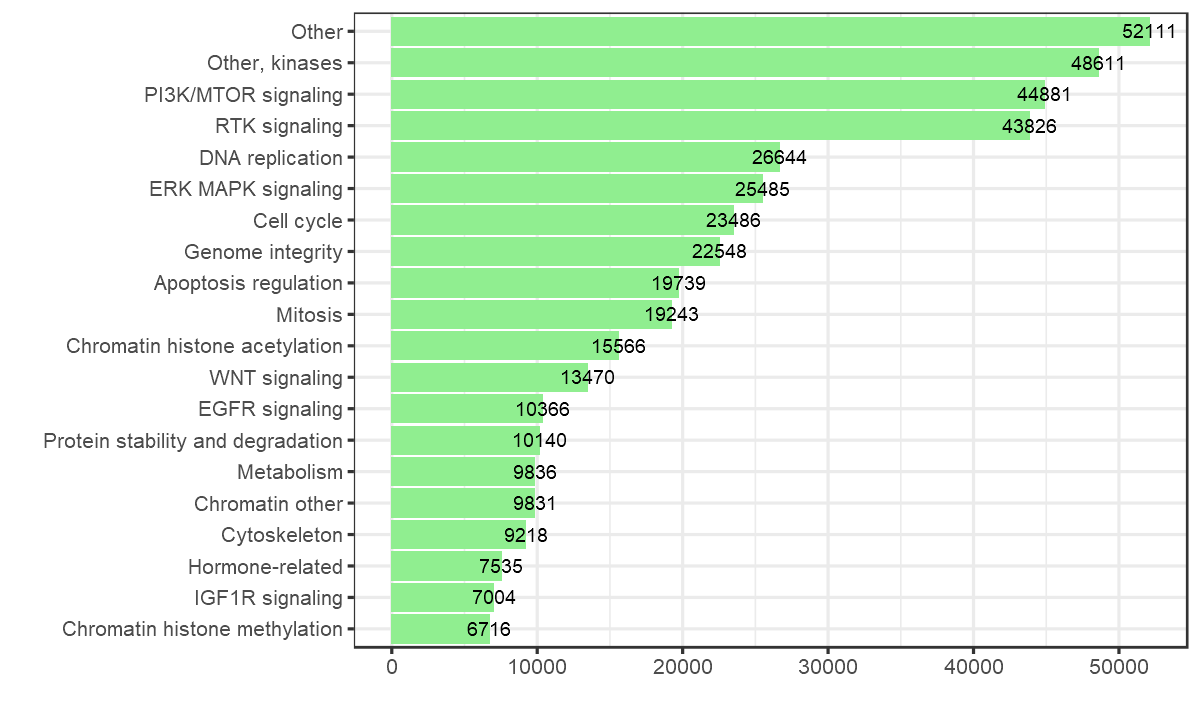

In [177]:
as.data.frame(table(c(GDSC1_dose_response$PATHWAY_NAME,GDSC2_dose_response$PATHWAY_NAME))) %>% arrange(desc(Freq)) %>% head(20) %>% 
mutate(temp=fct_reorder(Var1,-desc(Freq))) %>% 
ggplot(aes(y=temp,x=Freq))+geom_bar(stat="identity",fill="lightgreen")+theme_bw(base_size = 15)+
xlab("")+ylab("")+geom_text(aes(y=temp,x=Freq,label=Freq))

In [27]:
as.data.frame(table(c(GDSC1_dose_response$PATHWAY_NAME,GDSC2_dose_response$PATHWAY_NAME))) %>% dim()

[1] 24  2

#### 细胞系分布

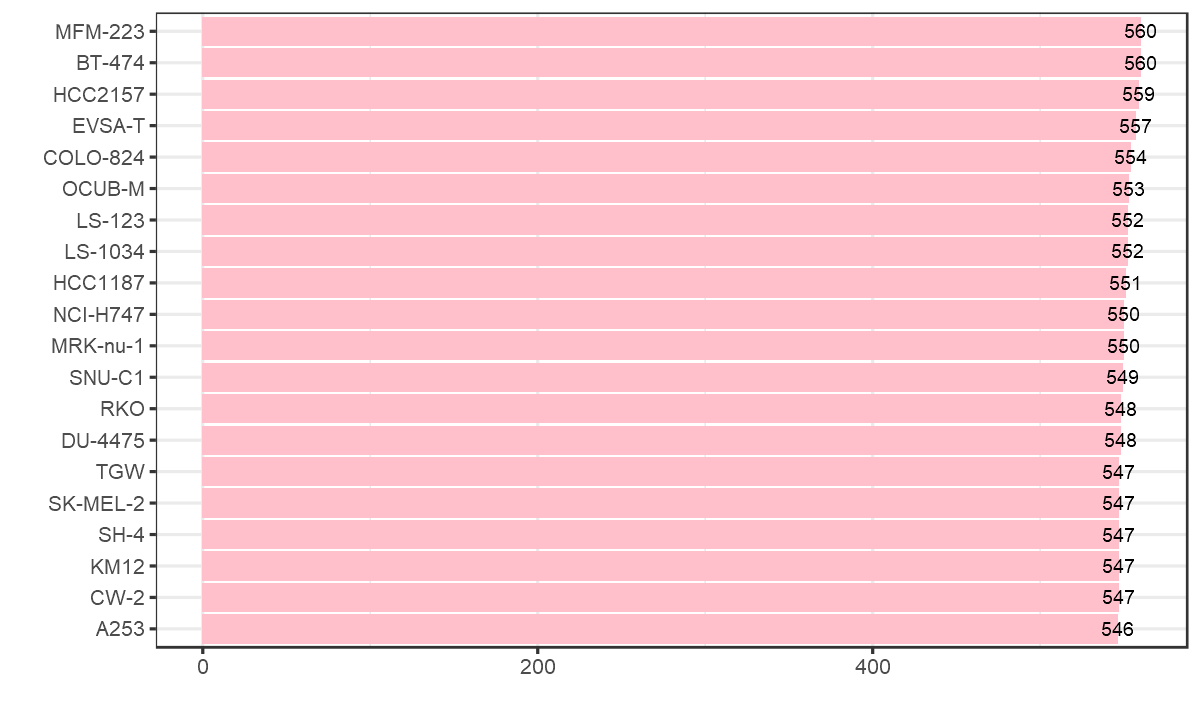

In [182]:
CCL_df=as.data.frame(table(c(GDSC1_dose_response$CELL_LINE_NAME,GDSC2_dose_response$CELL_LINE_NAME))) %>% arrange(desc(Freq))
head(CCL_df,20)%>% 
mutate(temp=fct_reorder(Var1,-desc(Freq))) %>% 
ggplot(aes(y=temp,x=Freq))+geom_bar(stat="identity",fill="pink")+theme_bw(base_size = 15)+
xlab("")+ylab("")+geom_text(aes(y=temp,x=Freq,label=Freq))

In [29]:
as.data.frame(table(c(GDSC1_dose_response$CELL_LINE_NAME,GDSC2_dose_response$CELL_LINE_NAME))) %>% arrange(desc(Freq)) %>% dim()

[1] 988   2

#### conclusions

+ IC50 是ln转换后的，符合正态分布

+ 药物分布，一共有400多种药物

+ pathway， 药物靶点涉及24个pathway

+ 细胞系，一共涵盖988例细胞系

### Cancer Cell line 表达数据

+ 表达数据，Expression_22Q1_Public: 下载的为处理后的，没有rawcounts值

+ 突变数据，Mutation_22Q1_Public: 下载的处理后的，one-code matrix

In [31]:
CCLE_RNAseq<-data.table::fread("D:\\CCLE\\CCLE_RNAseq_genes_counts_20180929.txt")
CCLE_RNAseq

Name,Description,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972.4,DDX11L1,12,8,8,6,2,1,4,3,...,18,14,40,39,25,14,11,5,13,6
ENSG00000227232.4,WASH7P,1340,821,678,677,884,868,611,692,...,562,328,663,270,233,558,309,811,500,945
ENSG00000243485.2,MIR1302-11,4,1,3,3,2,6,3,4,...,11,7,24,24,20,6,3,1,6,5
ENSG00000237613.2,FAM138A,6,3,2,4,1,4,3,1,...,14,16,31,19,24,8,7,0,10,4
ENSG00000268020.2,OR4G4P,0,2,3,1,1,0,1,2,...,8,3,15,7,5,3,5,4,3,2
ENSG00000240361.1,OR4G11P,4,5,3,5,1,5,4,0,...,8,7,25,16,18,7,6,0,10,2
ENSG00000186092.4,OR4F5,6,8,1,4,2,1,3,0,...,16,9,12,17,19,17,4,1,4,2
ENSG00000238009.2,RP11-34P13.7,21,10,3,6,6,3,0,3,...,4,10,13,10,8,3,3,2,17,14
ENSG00000233750.3,CICP27,47,39,67,45,24,30,31,33,...,71,200,111,120,68,54,43,20,64,41


In [32]:
dim(CCLE_RNAseq)

[1] 56202  1021

一共有1021个cancer cell lines，涉及56202 个基因

### 提取共有数据

对于有IC50值得细胞系，提取其表达值

#### 有表达值的细胞系

In [39]:
CCLNames=colnames(CCLE_RNAseq)
head(CCLNames)

[1] "Name"                 "Description"          "22RV1_PROSTATE"      
[4] "2313287_STOMACH"      "253JBV_URINARY_TRACT" "253J_URINARY_TRACT"

#### 有IC50值的细胞系

In [40]:
ic50_ccl=CCL_df$Var1
head(ic50_ccl)

[1] BT-474   MFM-223  HCC2157  EVSA-T   COLO-824 OCUB-M  
988 Levels: 201T 22RV1 23132-87 42-MG-BA 451Lu 5637 639-V 647-V 697 ... ZR-75-30

In [47]:
CCLNames_df=data.frame("CCLNames"=CCLNames)
ic50_ccl_df=data.frame("ic50_ccl"=ic50_ccl)
CCLNames_df$id=gsub("([::alpha::]*)\\_.*","\\1",CCLNames_df$CCLNames)
ic50_ccl_df$id=gsub("\\-","",ic50_ccl_df$ic50_ccl)
head(CCLNames_df,5)

,CCLNames,id
,<fct>,<chr>
1,Name,Name
2,Description,Description
3,22RV1_PROSTATE,22RV1
4,2313287_STOMACH,2313287
5,253JBV_URINARY_TRACT,253JBV


In [44]:
head(ic50_ccl_df)

,ic50_ccl,id
,<fct>,<chr>
1,BT-474,BT474
2,MFM-223,MFM223
3,HCC2157,HCC2157
4,EVSA-T,EVSAT
5,COLO-824,COLO824
6,OCUB-M,OCUBM


In [48]:
print(dim(CCLNames_df));print(dim(ic50_ccl_df));

[1] 1021    2
[1] 988   2


#### 取交集

In [49]:
ic50_CLL_common=merge(
ic50_ccl_df,CCLNames_df,sort=F
)
head(ic50_CLL_common)

,id,ic50_ccl,CCLNames
,<chr>,<fct>,<fct>
1,BT474,BT-474,BT474_BREAST
2,HCC2157,HCC2157,HCC2157_BREAST
3,LS1034,LS-1034,LS1034_LARGE_INTESTINE
4,LS123,LS-123,LS123_LARGE_INTESTINE
5,HCC1187,HCC1187,HCC1187_BREAST
6,NCIH747,NCI-H747,NCIH747_LARGE_INTESTINE


In [51]:
dim(ic50_CLL_common)

[1] 592   3

一共获取有592例细胞系数据

+ 有几个细胞系名称不匹配，需要剔除

+ T-T -> TT_OESOPHAGUS
+ TT -> TT_THYROID
+ KMH-2 -> KMH2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
+ KM-H2 -> KMH2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE

In [76]:
ic50_CLL_common= ic50_CLL_common  %>% filter(ic50_ccl!="T-T") %>%  
filter(ic50_ccl!="TT") %>% 
filter(ic50_ccl!="KMH-2") %>% 
filter(ic50_ccl!="KM-H2")
dim(ic50_CLL_common)

[1] 586   3

<strong>一共有586例细胞系,既有表达值，又有IC50值

## 提取数据

由以上分析可知，选取细胞系的基因表达和IC50值结果

+ 基因表达数据

+ IC50数据

### IC50

In [52]:
GDSC=rbind(GDSC1_dose_response,GDSC2_dose_response)
head(GDSC)

DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,2.395685,0.982114,0.022521,-0.189576
GDSC1,281,12975300,684055,ES3,SIDM00265,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,3.140923,0.984816,0.031840,0.508635
GDSC1,281,12975647,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,3.968757,0.985693,0.026052,1.284229
GDSC1,281,12975980,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,2.692768,0.972699,0.110056,0.088760
GDSC1,281,12976330,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,2.478678,0.944462,0.087011,-0.111820
GDSC1,281,12976635,684072,SK-ES-1,SIDM01111,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2,2.034050,0.950763,0.016288,-0.528390


In [77]:
#根据`CELL_LINE_NAME`，选取IC50结果
GDSC_select=GDSC[GDSC$CELL_LINE_NAME %in% ic50_CLL_common$ic50_ccl,]
dim(GDSC_select)

[1] 270460     19

In [87]:
GDSC_select_IC50=GDSC_select  %>% select(c("CELL_LINE_NAME","LN_IC50","DRUG_NAME")) 
head(GDSC_select_IC50)

CELL_LINE_NAME,LN_IC50,DRUG_NAME
<chr>,<dbl>,<chr>
SK-ES-1,2.034050,Erlotinib
COLO-829,2.966952,Erlotinib
8-MG-BA,2.494802,Erlotinib
GB-1,3.604860,Erlotinib
U-87-MG,3.877827,Erlotinib
NCI-H1648,-3.130514,Erlotinib


In [88]:
GDSC_select_IC50$CCLNames=ic50_CLL_common[match(GDSC_select_IC50$CELL_LINE_NAME,ic50_CLL_common$ic50_ccl),"CCLNames"]
head(GDSC_select_IC50)

CELL_LINE_NAME,LN_IC50,DRUG_NAME,CCLNames
<chr>,<dbl>,<chr>,<fct>
SK-ES-1,2.034050,Erlotinib,SKES1_BONE
COLO-829,2.966952,Erlotinib,COLO829_SKIN
8-MG-BA,2.494802,Erlotinib,8MGBA_CENTRAL_NERVOUS_SYSTEM
GB-1,3.604860,Erlotinib,GB1_CENTRAL_NERVOUS_SYSTEM
U-87-MG,3.877827,Erlotinib,U87MG_CENTRAL_NERVOUS_SYSTEM
NCI-H1648,-3.130514,Erlotinib,NCIH1648_LUNG


In [89]:
length(unique(GDSC_select_IC50$CCLNames))

[1] 586

In [127]:
GDSC_select_IC50 %>% write.csv(.,"GDSC_select_IC50.csv")

### RNAseq

基于RNAseq的表达结果，一共586个细胞系

In [121]:
selections=c(as.character(unique(GDSC_select_IC50$CCLNames)))
CCLE_RNAseq_select=CCLE_RNAseq[,..selections]
rownames(CCLE_RNAseq_select)=CCLE_RNAseq$Name

In [125]:
head(CCLE_RNAseq_select)

SKES1_BONE,COLO829_SKIN,8MGBA_CENTRAL_NERVOUS_SYSTEM,GB1_CENTRAL_NERVOUS_SYSTEM,U87MG_CENTRAL_NERVOUS_SYSTEM,NCIH1648_LUNG,NCIH1838_LUNG,DMS114_LUNG,NCIH1092_LUNG,NCIH1694_LUNG,...,NCIN87_STOMACH,SKMEL31_SKIN,ZR7530_BREAST,MKN7_STOMACH,CL40_LARGE_INTESTINE,HCC366_LUNG,CL34_LARGE_INTESTINE,JEKO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLM16_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
10,19,0,6,4,10,14,2,86,7,...,14,6,6,12,21,1,17,2,14,22
1082,914,1145,768,674,919,1713,1414,1458,515,...,1838,1057,945,634,732,533,1434,1232,1413,1893
2,8,2,1,2,6,6,1,6,4,...,4,6,5,3,5,4,6,4,3,3
0,9,2,3,0,11,3,0,3,2,...,6,4,4,10,16,0,8,4,11,3
4,1,2,2,1,2,6,3,0,1,...,5,2,2,1,4,0,5,0,5,1
3,5,3,1,2,4,3,0,0,1,...,9,6,2,5,5,1,7,1,4,7


In [128]:
CCLE_RNAseq_select %>%  write.csv(.,"CCLE_RNAseq_select.csv")

In [129]:
head(CCLE_RNAseq)

Name,Description,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972.4,DDX11L1,12,8,8,6,2,1,4,3,...,18,14,40,39,25,14,11,5,13,6
ENSG00000227232.4,WASH7P,1340,821,678,677,884,868,611,692,...,562,328,663,270,233,558,309,811,500,945
ENSG00000243485.2,MIR1302-11,4,1,3,3,2,6,3,4,...,11,7,24,24,20,6,3,1,6,5
ENSG00000237613.2,FAM138A,6,3,2,4,1,4,3,1,...,14,16,31,19,24,8,7,0,10,4
ENSG00000268020.2,OR4G4P,0,2,3,1,1,0,1,2,...,8,3,15,7,5,3,5,4,3,2
ENSG00000240361.1,OR4G11P,4,5,3,5,1,5,4,0,...,8,7,25,16,18,7,6,0,10,2


In [132]:
length(unique(CCLE_RNAseq$Description));length(unique(CCLE_RNAseq$Name));

[1] 54271

[1] 56202

有2k多个重复基因,这些基因君不是编码基因，暂时可以采用直接剔除的方式进行去重

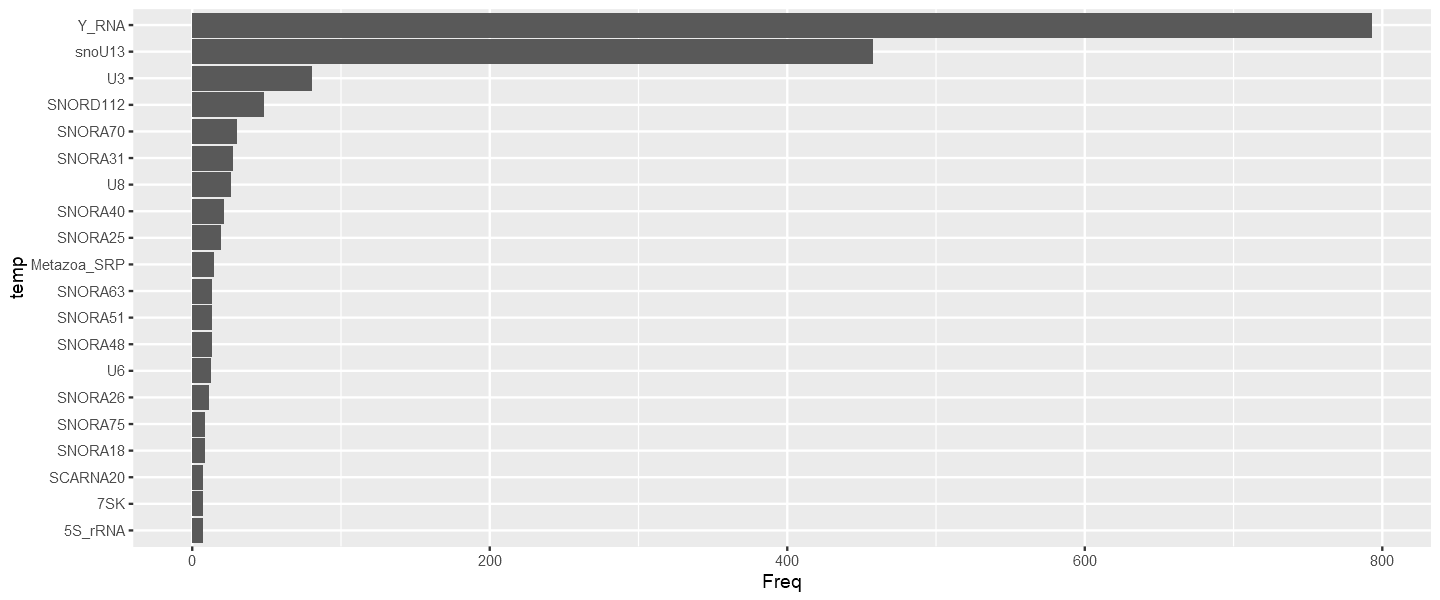

In [144]:
table(CCLE_RNAseq$Description) %>% as.data.frame() %>% 
arrange(desc(Freq)) %>% head(20) %>% mutate(temp=fct_reorder(Var1,-desc(Freq))) %>% 
ggplot(aes(y=temp,x=Freq))+geom_bar(stat="identity")

In [145]:
CCLE_RNAseq_select$Description=CCLE_RNAseq$Description
head(CCLE_RNAseq_select)

SKES1_BONE,COLO829_SKIN,8MGBA_CENTRAL_NERVOUS_SYSTEM,GB1_CENTRAL_NERVOUS_SYSTEM,U87MG_CENTRAL_NERVOUS_SYSTEM,NCIH1648_LUNG,NCIH1838_LUNG,DMS114_LUNG,NCIH1092_LUNG,NCIH1694_LUNG,...,SKMEL31_SKIN,ZR7530_BREAST,MKN7_STOMACH,CL40_LARGE_INTESTINE,HCC366_LUNG,CL34_LARGE_INTESTINE,JEKO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLM16_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Description
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
10,19,0,6,4,10,14,2,86,7,...,6,6,12,21,1,17,2,14,22,DDX11L1
1082,914,1145,768,674,919,1713,1414,1458,515,...,1057,945,634,732,533,1434,1232,1413,1893,WASH7P
2,8,2,1,2,6,6,1,6,4,...,6,5,3,5,4,6,4,3,3,MIR1302-11
0,9,2,3,0,11,3,0,3,2,...,4,4,10,16,0,8,4,11,3,FAM138A
4,1,2,2,1,2,6,3,0,1,...,2,2,1,4,0,5,0,5,1,OR4G4P
3,5,3,1,2,4,3,0,0,1,...,6,2,5,5,1,7,1,4,7,OR4G11P


In [159]:
CCLE_RNAseq_select_duplicated=CCLE_RNAseq_select  %>% distinct(.,Description,.keep_all=T)
dim(CCLE_RNAseq_select_duplicated);dim(CCLE_RNAseq_select)

[1] 54271   587

[1] 56202   587

In [161]:
genenames=CCLE_RNAseq_select_duplicated$Description
CCLE_RNAseq_select_duplicated=CCLE_RNAseq_select_duplicated[,1:(ncol(CCLE_RNAseq_select_duplicated)-1)]
rownames(CCLE_RNAseq_select_duplicated)=genenames
head(CCLE_RNAseq_select_duplicated)

SKES1_BONE,COLO829_SKIN,8MGBA_CENTRAL_NERVOUS_SYSTEM,GB1_CENTRAL_NERVOUS_SYSTEM,U87MG_CENTRAL_NERVOUS_SYSTEM,NCIH1648_LUNG,NCIH1838_LUNG,DMS114_LUNG,NCIH1092_LUNG,NCIH1694_LUNG,...,NCIN87_STOMACH,SKMEL31_SKIN,ZR7530_BREAST,MKN7_STOMACH,CL40_LARGE_INTESTINE,HCC366_LUNG,CL34_LARGE_INTESTINE,JEKO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLM16_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
10,19,0,6,4,10,14,2,86,7,...,14,6,6,12,21,1,17,2,14,22
1082,914,1145,768,674,919,1713,1414,1458,515,...,1838,1057,945,634,732,533,1434,1232,1413,1893
2,8,2,1,2,6,6,1,6,4,...,4,6,5,3,5,4,6,4,3,3
0,9,2,3,0,11,3,0,3,2,...,6,4,4,10,16,0,8,4,11,3
4,1,2,2,1,2,6,3,0,1,...,5,2,2,1,4,0,5,0,5,1
3,5,3,1,2,4,3,0,0,1,...,9,6,2,5,5,1,7,1,4,7


In [162]:
CCLE_RNAseq_select_duplicated %>%  write.csv(.,"CCLE_RNAseq_select_duplicated.csv")

## 耐药性分析

通过不同的case，来诠释如何发现：与耐药相关的gene 表达。

### Ibrutinib耐药

#### 选取有Ibrutinib耐药数据的细胞系

In [2]:
GDSC_select_IC50<-read.csv("GDSC_select_IC50.csv",row.names = 1)
head(GDSC_select_IC50 )

,CELL_LINE_NAME,LN_IC50,DRUG_NAME,CCLNames
,<fct>,<dbl>,<fct>,<fct>
1,SK-ES-1,2.034050,Erlotinib,SKES1_BONE
2,COLO-829,2.966952,Erlotinib,COLO829_SKIN
3,8-MG-BA,2.494802,Erlotinib,8MGBA_CENTRAL_NERVOUS_SYSTEM
4,GB-1,3.604860,Erlotinib,GB1_CENTRAL_NERVOUS_SYSTEM
5,U-87-MG,3.877827,Erlotinib,U87MG_CENTRAL_NERVOUS_SYSTEM
6,NCI-H1648,-3.130514,Erlotinib,NCIH1648_LUNG


In [3]:
select_cells=GDSC_select_IC50  %>% filter(DRUG_NAME=="Ibrutinib") %>% pull(CCLNames) %>% as.character
length(select_cells)

[1] 455

In [4]:
CCLE_RNAseq_expression=read.csv("CCLE_RNAseq_select_duplicated.csv",row.names = 1,check.names = F)
head(CCLE_RNAseq_expression)

,SKES1_BONE,COLO829_SKIN,8MGBA_CENTRAL_NERVOUS_SYSTEM,GB1_CENTRAL_NERVOUS_SYSTEM,U87MG_CENTRAL_NERVOUS_SYSTEM,NCIH1648_LUNG,NCIH1838_LUNG,DMS114_LUNG,NCIH1092_LUNG,NCIH1694_LUNG,...,NCIN87_STOMACH,SKMEL31_SKIN,ZR7530_BREAST,MKN7_STOMACH,CL40_LARGE_INTESTINE,HCC366_LUNG,CL34_LARGE_INTESTINE,JEKO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLM16_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
DDX11L1,10,19,0,6,4,10,14,2,86,7,...,14,6,6,12,21,1,17,2,14,22
WASH7P,1082,914,1145,768,674,919,1713,1414,1458,515,...,1838,1057,945,634,732,533,1434,1232,1413,1893
MIR1302-11,2,8,2,1,2,6,6,1,6,4,...,4,6,5,3,5,4,6,4,3,3
FAM138A,0,9,2,3,0,11,3,0,3,2,...,6,4,4,10,16,0,8,4,11,3
OR4G4P,4,1,2,2,1,2,6,3,0,1,...,5,2,2,1,4,0,5,0,5,1
OR4G11P,3,5,3,1,2,4,3,0,0,1,...,9,6,2,5,5,1,7,1,4,7


In [5]:
select_expressions=CCLE_RNAseq_expression[,select_cells]
dim(select_expressions)

[1] 54271   455

Gene数目太多，耗时太久，需要剔除一些基因

In [6]:
library(easyConvert)
temp=easyConvert(
    species="HUMAN",
    queryList=rownames(select_expressions),
    queryType=c("SYMBOL")
)
head(temp)

,SYMBOL,ENTREZID,ALIAS,ENSEMBL,TYPE,NCBI,Entrez_Gene_Summary,CIViC_Summary,GeneCards_Summary
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
21163,DDX11L1,100287102,-,ENSG00000223972,pseudo,NR_046018,NA,NA,NA
19739,WASH7P,653635,FAM39F;WASH5P,HGNC:HGNC:38034,pseudo,NR_024540,NA,NA,NA
21625,MIR1302-11,100422919,-,ENSG00000282807,ncRNA,NR_036268;NR_036268_2;NR_036268_3;NR_036268_4,NA,NA,NA
19544,FAM138A,645520,F379;FAM138F,ENSG00000237613,ncRNA,NR_026818;NR_026818_2;NR_026818_3,NA,NA,NA
30894,OR4G4P,79504,-,HGNC:HGNC:14822,pseudo,NA,NA,NA,NA
30893,OR4G11P,403263,-,HGNC:HGNC:31276,pseudo,NA,NA,NA,NA


In [7]:
#选择Protein-coding GENE
selections=temp %>% filter(TYPE=="protein-coding") %>% pull(SYMBOL) %>% as.character()
select_expressions=select_expressions[selections,]
dim(select_expressions)

[1] 18504   455

#### 进行GSVA分析

In [1]:
library(GSVA)
library(msigdbr)
library(dplyr)

Warning message:
"package 'msigdbr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [8]:
#选取C2 term下的pathway
C2=msigdbr(species = "Homo sapiens", category = "C2") %>% 
  dplyr::select(gs_name, entrez_gene,gene_symbol)

In [9]:
#将term转换为geneset
msig2set<-function(gs){
  go_list=list()
  for(i in unique(gs$gs_name)){
    go_df=gs[gs$gs_name==i,]
    go_list[i]=list(go_df$gene_symbol)
  }
  return(go_list)
}
c2=msig2set(C2)

In [ ]:
#select_expressions=as.matrix(select_expressions)
gsva_results_C2 <- gsva(select_expressions, c2,kcdf="Poisson", 
                     verbose=TRUE)
#gene数目太多，耗时太久，需要剔除一些基因

Warning message in .local(expr, gset.idx.list, ...):
"48 genes with constant expression values throuhgout the samples."
Warning message in .local(expr, gset.idx.list, ...):
"Since argument method!="ssgsea", genes with constant expression values are discarded."


In [240]:
write.csv(gsva_results_C2,
          "gsva_results_C2.csv")

In [9]:
gsva_results_C2=read.csv("gsva_results_C2.csv",row.names = 1)
gsva_df=as.data.frame(t(gsva_results_C2))
head(gsva_df)

,ABBUD_LIF_SIGNALING_1_DN,ABBUD_LIF_SIGNALING_1_UP,ABBUD_LIF_SIGNALING_2_DN,ABBUD_LIF_SIGNALING_2_UP,ABDELMOHSEN_ELAVL4_TARGETS,ABDULRAHMAN_KIDNEY_CANCER_VHL_DN,ABE_INNER_EAR,ABE_VEGFA_TARGETS,ABE_VEGFA_TARGETS_2HR,ABE_VEGFA_TARGETS_30MIN,...,ZIRN_TRETINOIN_RESPONSE_WT1_UP,ZWANG_CLASS_1_TRANSIENTLY_INDUCED_BY_EGF,ZWANG_CLASS_2_TRANSIENTLY_INDUCED_BY_EGF,ZWANG_CLASS_3_TRANSIENTLY_INDUCED_BY_EGF,ZWANG_DOWN_BY_2ND_EGF_PULSE,ZWANG_EGF_INTERVAL_DN,ZWANG_EGF_INTERVAL_UP,ZWANG_EGF_PERSISTENTLY_DN,ZWANG_EGF_PERSISTENTLY_UP,ZWANG_TRANSIENTLY_UP_BY_2ND_EGF_PULSE_ONLY
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A673_BONE,-0.45096817,-0.45272501,0.1778654,-0.36567868,0.15827921,-0.130596746,0.08714497,-0.1556067,-0.4303903,-0.18816890,...,-0.19687580,-0.36490062,-0.3807739,-0.4212052,-0.02260065,-0.302742158,-0.3446732,-0.2888046,0.19311708,-0.1977006
SKES1_BONE,-0.42344075,-0.64454327,0.3238756,-0.46449219,-0.26699246,-0.190105752,-0.03150029,-0.2143938,-0.3760705,-0.27325611,...,-0.36801185,-0.38930868,-0.6269704,-0.4857908,0.20226536,-0.326454334,-0.5196238,-0.4474963,-0.17236448,-0.1779395
COLO829_SKIN,0.01620619,-0.30785415,0.2759617,-0.31141101,0.17849778,0.076540760,0.22259619,0.1608538,0.2677291,0.08861612,...,0.19328797,-0.05000329,-0.4710934,-0.0733438,-0.29099409,-0.138003214,-0.5155757,-0.3099438,0.17209704,-0.1359536
X5637_URINARY_TRACT,-0.10008347,0.00975855,0.1492283,0.15805767,0.32473495,-0.124381152,0.06550235,0.3573209,0.1270012,-0.28482328,...,0.33098820,0.21235244,-0.2763073,0.3123889,-0.30856242,-0.012847737,-0.4014972,0.1799263,-0.07945129,-0.2265970
RT4_URINARY_TRACT,-0.13577132,-0.21214105,0.1159525,-0.02703763,-0.09679806,0.009071214,-0.18136983,-0.1110501,-0.1352497,-0.39525041,...,-0.07985007,0.03446999,-0.2418453,0.1220141,-0.09471461,-0.006833445,-0.4155319,0.1990041,0.31504531,-0.2976482
SW780_URINARY_TRACT,-0.36446447,-0.25343200,-0.3267466,-0.19057435,-0.43167765,-0.118420630,-0.36568356,-0.2151232,-0.3028082,-0.52183117,...,0.10525251,-0.04955563,-0.5862085,-0.1070873,0.08732348,0.025211366,-0.5898014,0.1400906,-0.07729625,-0.3038190


In [10]:
ic50_value=GDSC_select_IC50  %>% filter(DRUG_NAME=="Ibrutinib")  %>% pull(LN_IC50) %>% as.numeric()

#### 相关性分析

In [8]:
#计算 IC50 与 GSVA score的相关性
corTest=do.call(rbind,apply(gsva_df,2,function(x){
    temp=cor.test(x,ic50_value,method = "spearman")
    a=temp$estimate
    names(a)=temp$data.name
    df=data.frame(pvalue=temp$p.value,cor=temp$estimate)
    return(df)
}))

Warning message in cor.test.default(x, ic50_value, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, ic50_value, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, ic50_value, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x, ic50_value, method = "spearman"):
"Cannot compute exact p-value with ties"


In [9]:
head(corTest)

,pvalue,cor
,<dbl>,<dbl>
ABBUD_LIF_SIGNALING_1_DN,0.020513038,0.10862623
ABBUD_LIF_SIGNALING_1_UP,0.442404425,0.03608704
ABBUD_LIF_SIGNALING_2_DN,0.024260361,0.10564559
ABBUD_LIF_SIGNALING_2_UP,0.001883204,0.14546095
ABDELMOHSEN_ELAVL4_TARGETS,0.028442170,0.10275732
ABDULRAHMAN_KIDNEY_CANCER_VHL_DN,0.242205819,0.05492454


#### 负相关

In [10]:
corTest  %>% filter(pvalue<0.05&cor< -0.2)  %>% arrange(-desc(cor)) %>% head(10)

,pvalue,cor
,<dbl>,<dbl>
HEIDENBLAD_AMPLICON_12P11_12_DN,1.310071e-08,-0.2635129
WP_MICROGLIA_PATHOGEN_PHAGOCYTOSIS_PATHWAY,1.409858e-08,-0.2629468
COLLIS_PRKDC_SUBSTRATES,1.620693e-08,-0.2618684
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_GRANULOPOIESIS,2.072504e-08,-0.2599541
KEGG_FC_EPSILON_RI_SIGNALING_PATHWAY,8.215973e-08,-0.2489448
REACTOME_TRANSCRIPTION_OF_E2F_TARGETS_UNDER_NEGATIVE_CONTROL_BY_DREAM_COMPLEX,1.297196e-07,-0.2451800
SHIN_B_CELL_LYMPHOMA_CLUSTER_9,2.124908e-07,-0.2410433
LEE_DIFFERENTIATING_T_LYMPHOCYTE,2.160989e-07,-0.2409009
CHIARETTI_T_ALL_RELAPSE_PROGNOSIS,3.078375e-07,-0.2378875


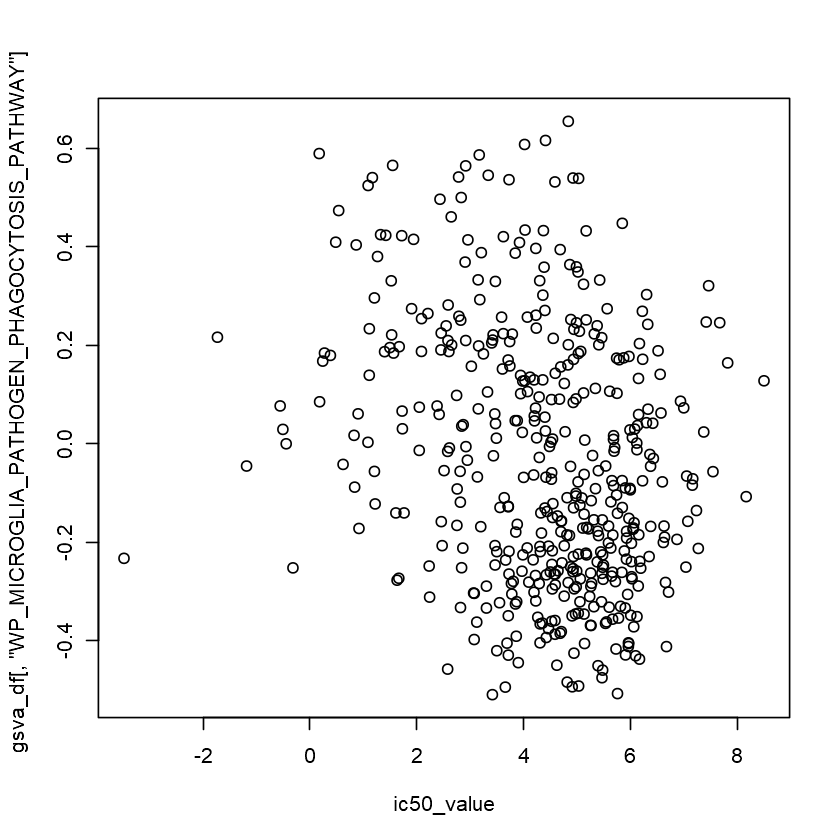

In [13]:
plot(ic50_value,gsva_df[,"WP_MICROGLIA_PATHOGEN_PHAGOCYTOSIS_PATHWAY"])

#### 正相关

In [11]:
corTest  %>% filter(pvalue<0.05&cor> 0.25)  %>% arrange(desc(cor)) %>% head(15)

,pvalue,cor
,<dbl>,<dbl>
LOPEZ_MESOTHELIOMA_SURVIVAL_WORST_VS_BEST_UP,3.114721e-13,0.3346163
ZHONG_RESPONSE_TO_AZACITIDINE_AND_TSA_UP,8.877626e-12,0.3143173
XU_HGF_SIGNALING_NOT_VIA_AKT1_6HR,1.152673e-11,0.3126614
VERRECCHIA_RESPONSE_TO_TGFB1_C5,1.316583e-10,0.2966829
HASINA_NOL7_TARGETS_UP,1.626240e-10,0.2952497
TONKS_TARGETS_OF_RUNX1_RUNX1T1_FUSION_SUSTAINED_IN_MONOCYTE_UP,1.904116e-10,0.2941743
ALONSO_METASTASIS_EMT_UP,3.965582e-10,0.2891134
KAPOSI_LIVER_CANCER_MET_UP,4.462697e-10,0.2882894
MULLIGAN_NTF3_SIGNALING_VIA_INSR_AND_IGF1R_DN,5.298341e-10,0.2870872


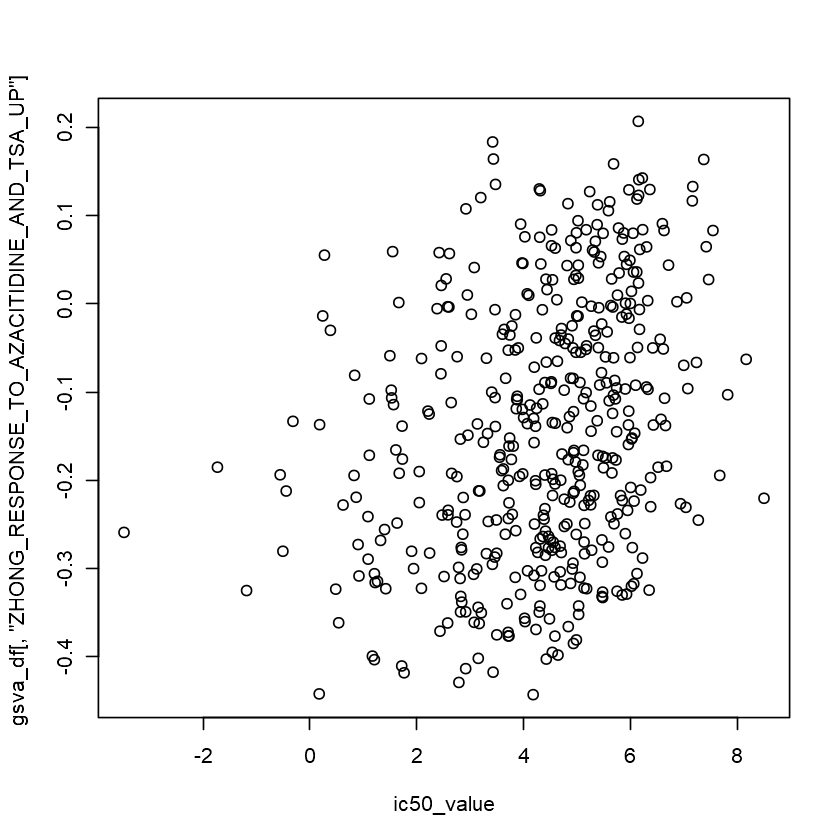

In [15]:
plot(ic50_value,gsva_df[,"ZHONG_RESPONSE_TO_AZACITIDINE_AND_TSA_UP"])

#### 分析矫正

每个样本的library size相差太多

In [15]:
summary(colSums(select_expressions))
#文库大小查的有点多，最大相差8倍，这样很影响GSVA分析结果，需要尝试过滤下样本

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 33660321  98418348 112055692 112820226 128738236 240080154 

尝试选择25%分位，75%分位之间的样本进行GSVA分析

In [20]:
q1st=quantile(colSums(select_expressions),0.25)
q3rd=quantile(colSums(select_expressions),0.75)

In [30]:
selections=colSums(select_expressions)> as.numeric(q1st)&colSums(select_expressions)< as.numeric(q3rd)

In [31]:
select_expressions_tpm=select_expressions[,selections]

过滤掉了50%的样本！

In [35]:
select_expressions_tpm=as.matrix(select_expressions_tpm)
gsva_results_C2 <- gsva(select_expressions_tpm, c2,kcdf="Poisson", 
                     verbose=TRUE)

Warning message in .local(expr, gset.idx.list, ...):
"58 genes with constant expression values throuhgout the samples."
Warning message in .local(expr, gset.idx.list, ...):
"Since argument method!="ssgsea", genes with constant expression values are discarded."


Estimating GSVA scores for 6288 gene sets.
Computing observed enrichment scores
Estimating ECDFs with Poisson kernels
Using parallel with 4 cores
  |======================================================================| 100%


In [36]:
write.csv(gsva_results_C2,
          "gsva_results_C2_filter.csv")

In [39]:
gsva_results_C2_filter=read.csv("gsva_results_C2_filter.csv",row.names = 1,check.names = F)
head(gsva_results_C2_filter)

,42MGBA_CENTRAL_NERVOUS_SYSTEM,8MGBA_CENTRAL_NERVOUS_SYSTEM,A172_CENTRAL_NERVOUS_SYSTEM,GB1_CENTRAL_NERVOUS_SYSTEM,T98G_CENTRAL_NERVOUS_SYSTEM,U87MG_CENTRAL_NERVOUS_SYSTEM,CORL23_LUNG,NCIH1693_LUNG,NCIH2170_LUNG,NCIH2405_LUNG,...,KOPN8_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,L1236_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH1876_LUNG,OCIM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SUDHL10_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SUDHL6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SUPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SNU175_LARGE_INTESTINE,SNU407_LARGE_INTESTINE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABBUD_LIF_SIGNALING_1_DN,0.21363923,-0.2795370,-0.28041520,-0.03864335,-0.002982009,-0.22429840,-0.08165451,-0.22719561,0.15771312,-0.10336552,...,-0.4227369,-0.3602960,-0.3351741,-0.25585684,-0.1081913,-0.3328202,-0.35855099,-0.16001876,0.2244822,-0.04736455
ABBUD_LIF_SIGNALING_1_UP,0.05668879,-0.1979735,-0.22882298,-0.04802643,-0.041951085,-0.01533886,-0.06955307,-0.47060136,-0.06560949,-0.08931911,...,-0.2382743,-0.2945483,-0.5550523,-0.21560551,-0.3977602,-0.3938180,-0.20347589,-0.29939160,-0.4273239,-0.32837691
ABBUD_LIF_SIGNALING_2_DN,0.16366259,0.1093702,-0.06184605,-0.23160614,0.291370374,0.29188024,-0.73813862,0.21817187,0.02958314,-0.12535612,...,-0.3465586,-0.4796266,0.5109971,0.11882921,-0.1093335,-0.5622865,-0.31194433,0.10909542,-0.5350447,-0.37111903
ABBUD_LIF_SIGNALING_2_UP,0.48428165,0.2462030,0.33696629,0.25990724,0.033872121,0.38831489,-0.27055456,-0.40752325,0.05096987,0.38614740,...,-0.2573397,-0.3392096,0.1893841,-0.38690676,0.1813438,-0.1654576,-0.08878167,-0.54209441,-0.2275387,-0.01011785
ABDELMOHSEN_ELAVL4_TARGETS,-0.09343490,-0.1369343,0.46404299,0.18562662,0.308559953,0.16526302,-0.36454988,0.02923012,-0.01372832,-0.23432609,...,0.0280810,0.2112303,-0.2973893,-0.05731358,-0.1365000,-0.2738886,-0.30608182,-0.03660275,-0.1928477,-0.10204862
ABDULRAHMAN_KIDNEY_CANCER_VHL_DN,0.43115417,0.3139101,0.01116302,0.29342690,0.473732187,0.41921831,-0.60486406,-0.07842024,-0.01799291,-0.08770440,...,-0.4287030,-0.3723693,0.1303433,0.33462833,-0.2448931,-0.2810537,0.11085784,-0.09987030,0.2716853,-0.13508698


In [188]:
sampleInfo=data.frame("grp"=unlist(lapply(colnames(gsva_results_C2_filter),FUN=function(x){
    strsplit(gsub("([::alpha::]*\\_)(.*)","\\1;\\2",x),";")[[1]][2]
}))
                     )
rownames(sampleInfo)=colnames(gsva_results_C2_filter)
head(sampleInfo)

,grp
,<fct>
42MGBA_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
8MGBA_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
A172_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
GB1_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
T98G_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
U87MG_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM


In [113]:
ic50_value=GDSC_select_IC50  %>% filter(DRUG_NAME=="Ibrutinib")
rownames(ic50_value)=ic50_value$CCLNames
ic50_value=ic50_value[selections,]
ic50_value=ic50_value %>% pull(LN_IC50) %>% as.numeric()
head(ic50_value)

[1] 4.098416 4.673266 5.686058 5.671911 4.440302 4.314364

In [117]:
#计算 IC50 与 GSVA score的相关性a
corTest=do.call(rbind,apply(gsva_results_C2_filter,1,function(x){
    temp=cor.test(x,ic50_value,method = "spearman")
    a=temp$estimate
    names(a)=temp$data.name
    df=data.frame(pvalue=temp$p.value,cor=temp$estimate)
    return(df)
}))

In [119]:
head(corTest)

,pvalue,cor
,<dbl>,<dbl>
ABBUD_LIF_SIGNALING_1_DN,0.32522908,0.06555197
ABBUD_LIF_SIGNALING_1_UP,0.89506609,0.00879621
ABBUD_LIF_SIGNALING_2_DN,0.02036136,0.15398907
ABBUD_LIF_SIGNALING_2_UP,0.11187242,0.10579663
ABDELMOHSEN_ELAVL4_TARGETS,0.11123154,0.10598540
ABDULRAHMAN_KIDNEY_CANCER_VHL_DN,0.34633679,0.06275430


##### 正相关

即耐药，

In [121]:
corTest  %>% filter(pvalue<0.05&cor> 0.25)  %>% arrange(desc(cor)) %>% head(10)

,pvalue,cor
,<dbl>,<dbl>
LOPEZ_MESOTHELIOMA_SURVIVAL_WORST_VS_BEST_UP,2.842075e-06,0.3064547
REACTOME_NTRK2_ACTIVATES_RAC1,3.569086e-06,0.3034990
ZHONG_RESPONSE_TO_AZACITIDINE_AND_TSA_UP,3.972503e-06,0.3020986
REACTOME_AUTOPHAGY,4.894431e-06,0.2993492
REACTOME_CRMPS_IN_SEMA3A_SIGNALING,6.468279e-06,0.2956333
SAKAI_TUMOR_INFILTRATING_MONOCYTES_UP,6.564409e-06,0.2954353
KEGG_HYPERTROPHIC_CARDIOMYOPATHY_HCM,9.319565e-06,0.2906894
VERRECCHIA_RESPONSE_TO_TGFB1_C5,1.137514e-05,0.2879533
BIOCARTA_CDK5_PATHWAY,1.231706e-05,0.2868535


In [124]:
positive_terms=corTest  %>% filter(pvalue<0.05&cor> 0.25)  %>% arrange(desc(cor)) %>% head(50) %>% rownames(.)

In [191]:
gsva_results_C2_filter_select_positive=gsva_results_C2_filter[positive_terms,]

In [189]:
head(sampleInfo)

,grp
,<fct>
42MGBA_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
8MGBA_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
A172_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
GB1_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
T98G_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM
U87MG_CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM


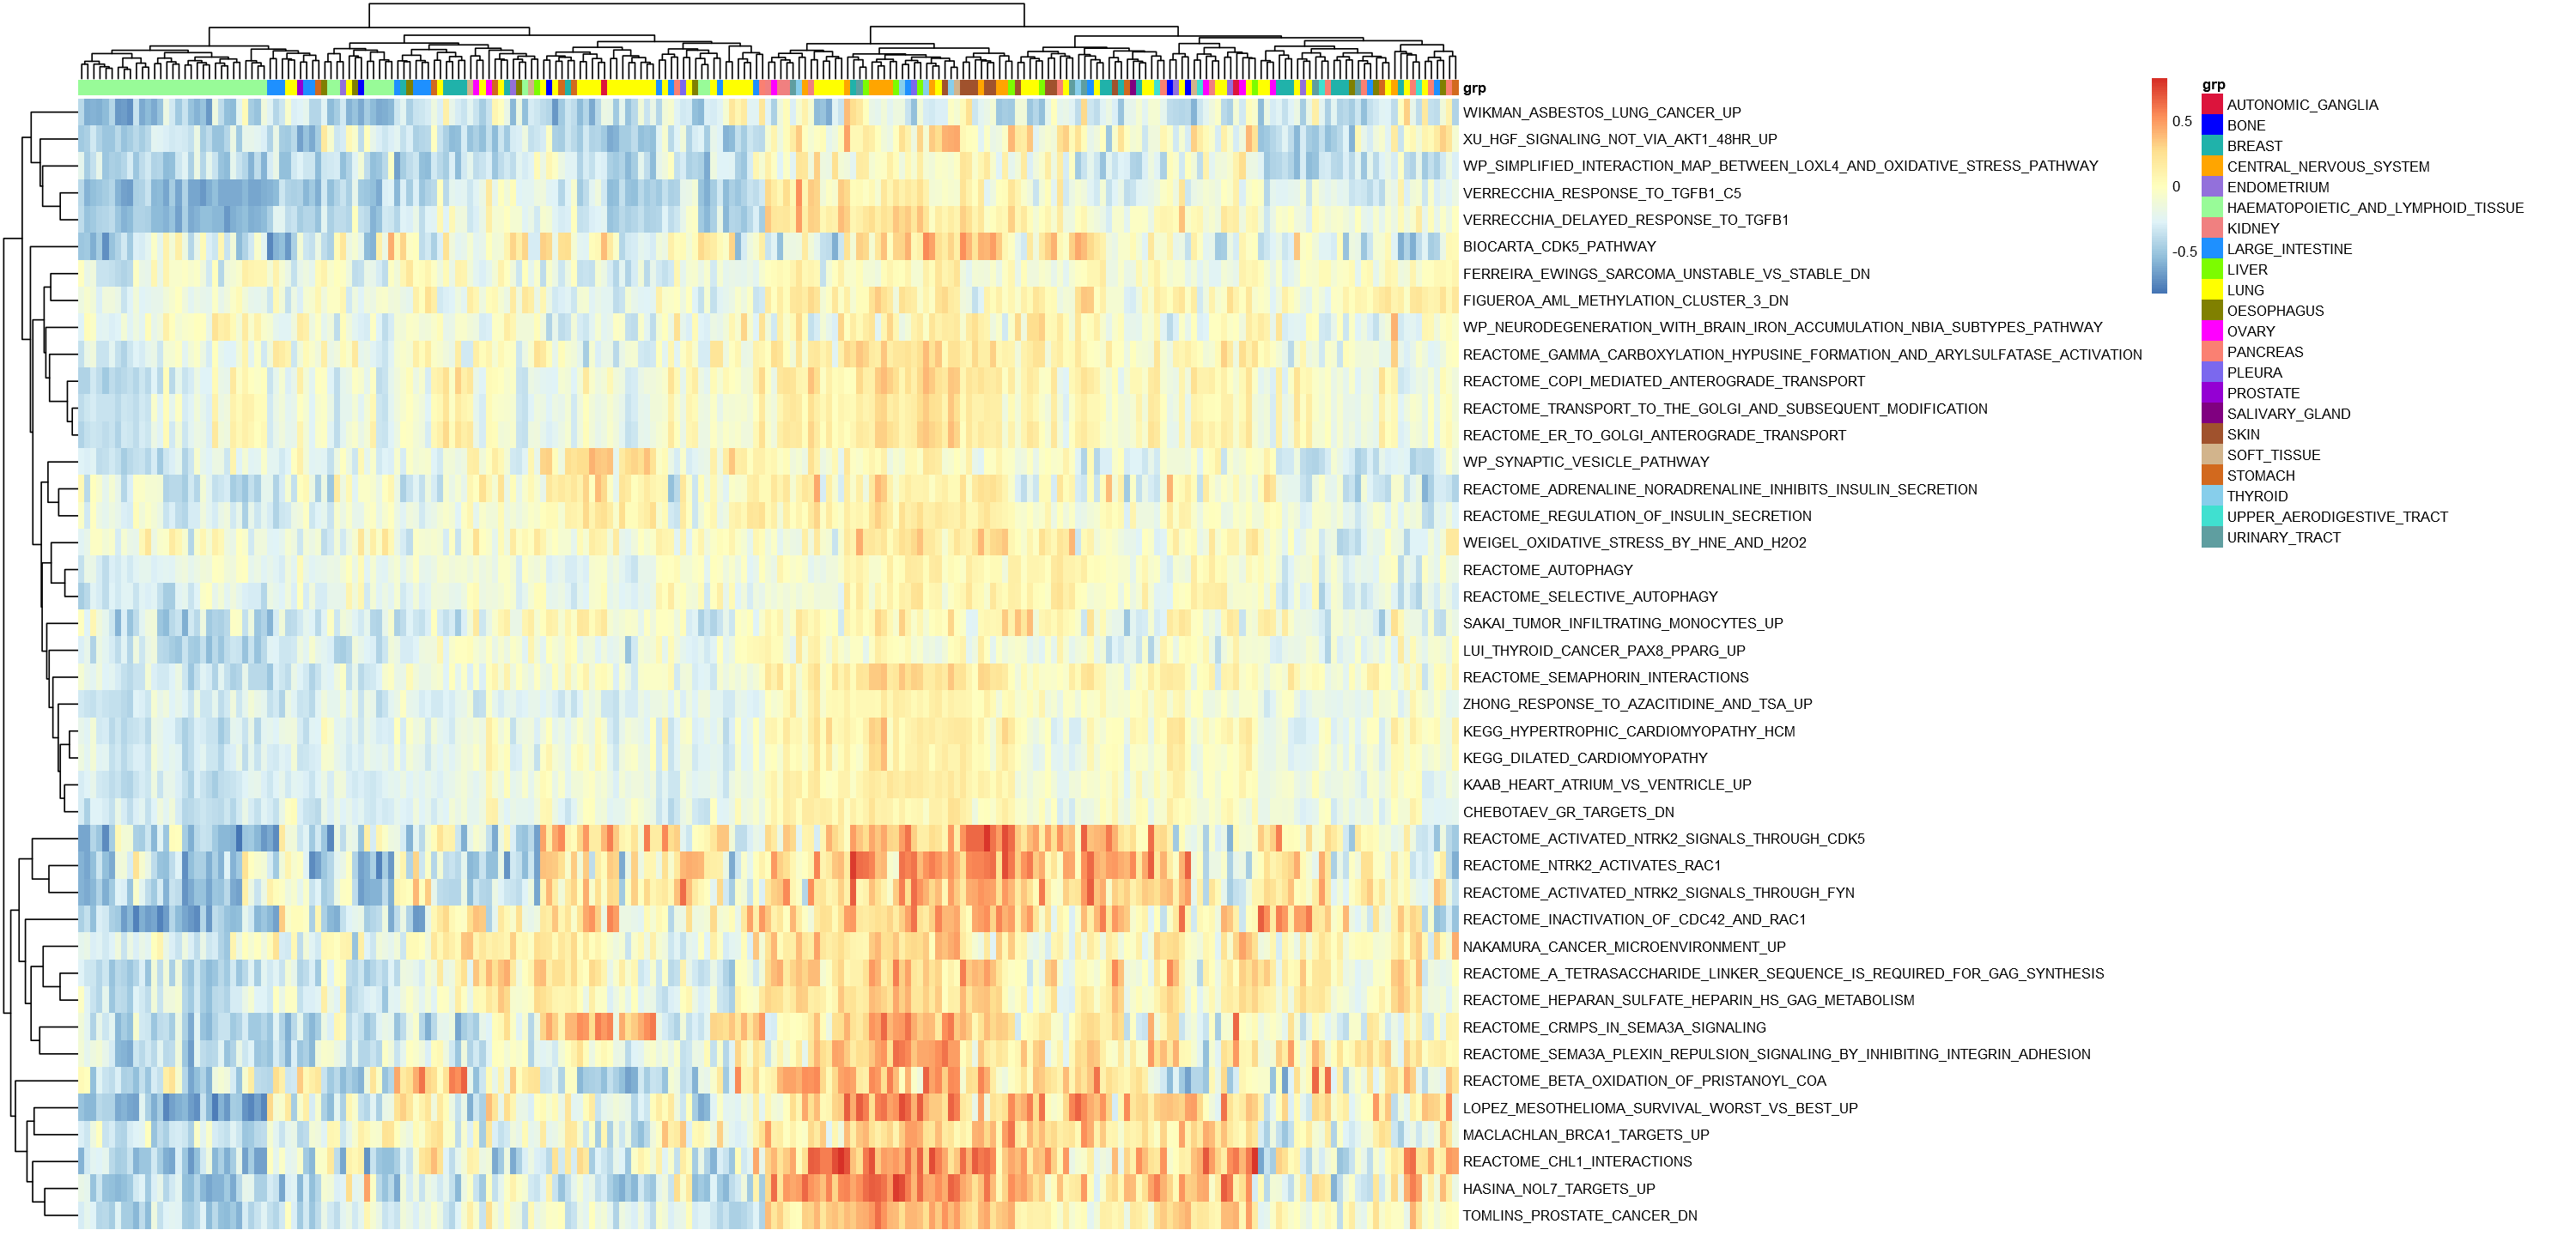

In [248]:
library(pheatmap)
options(repr.plot.width=25,repr.plot.height=12)
pheatmap(gsva_results_C2_filter_select_positive,
        show_rownames = T,
        show_colnames=F,
        #cellwidth=4,
        #cellheight=15,
        annotation_col=sampleInfo,
        annotation_colors=list(
        grp=color_select
        ),
         #filename="heatmap_positive_ibrutinib.pdf",
        scale="none")

###### Conclusions

这些terms与耐药较为相关，这些通路越活越，对drug 越是不应答

+ NTR2 activations
+ HAEMATOPOIETIC_AND_LYMPHOID_TISSUE IC50值普遍较低

In [222]:
color_clusters <- c("#DC143C", "#0000FF", "#20B2AA", "#FFA500", "#9370DB",
                    "#98FB98", "#F08080", "#1E90FF", "#7CFC00", "#FFFF00",
                    "#808000", "#FF00FF", "#FA8072", "#7B68EE", "#9400D3",
                    "#800080", "#A0522D", "#D2B48C", "#D2691E", "#87CEEB",
                    "#40E0D0", "#5F9EA0", "#FF1493", "#0000CD", "#008B8B",
                    "#FFE4B5", "#8A2BE2", "#228B22", "#E9967A", "#4682B4",
                    "#32CD32", "#F0E68C", "#FFFFE0", "#EE82EE", "#FF6347",
                    "#6A5ACD", "#9932CC", "#8B008B", "#8B4513", "#DEB887")

In [237]:
color_select=color_clusters[1:22]
names(color_select)=names(table(sampleInfo$grp))
#color_custom=lapply(color_select,FUN=function(x){x})

##### 负相关

即sensitive

In [254]:
corTest  %>% filter(pvalue<0.05&cor< -0.25)  %>% arrange(desc(cor)) %>% head()

,pvalue,cor
,<dbl>,<dbl>
JINESH_BLEBBISHIELD_TRANSFORMED_STEM_CELL_SPHERES_DN,1.303023e-04,-0.2519918
AUNG_GASTRIC_CANCER,1.181180e-04,-0.2535399
CROONQUIST_STROMAL_STIMULATION_DN,1.045554e-04,-0.2554502
REACTOME_TRANSCRIPTION_OF_E2F_TARGETS_UNDER_NEGATIVE_CONTROL_BY_DREAM_COMPLEX,9.195202e-05,-0.2574466
WP_MICROGLIA_PATHOGEN_PHAGOCYTOSIS_PATHWAY,7.704021e-05,-0.2601715
HOSHIDA_LIVER_CANCER_SUBCLASS_S2,7.629548e-05,-0.2603202


In [255]:
negative_terms=corTest  %>% filter(pvalue<0.05&cor< -0.2)  %>% arrange(desc(cor)) %>% head(50) %>% rownames(.)

In [256]:
gsva_results_C2_filter_select_negative=gsva_results_C2_filter[negative_terms,]

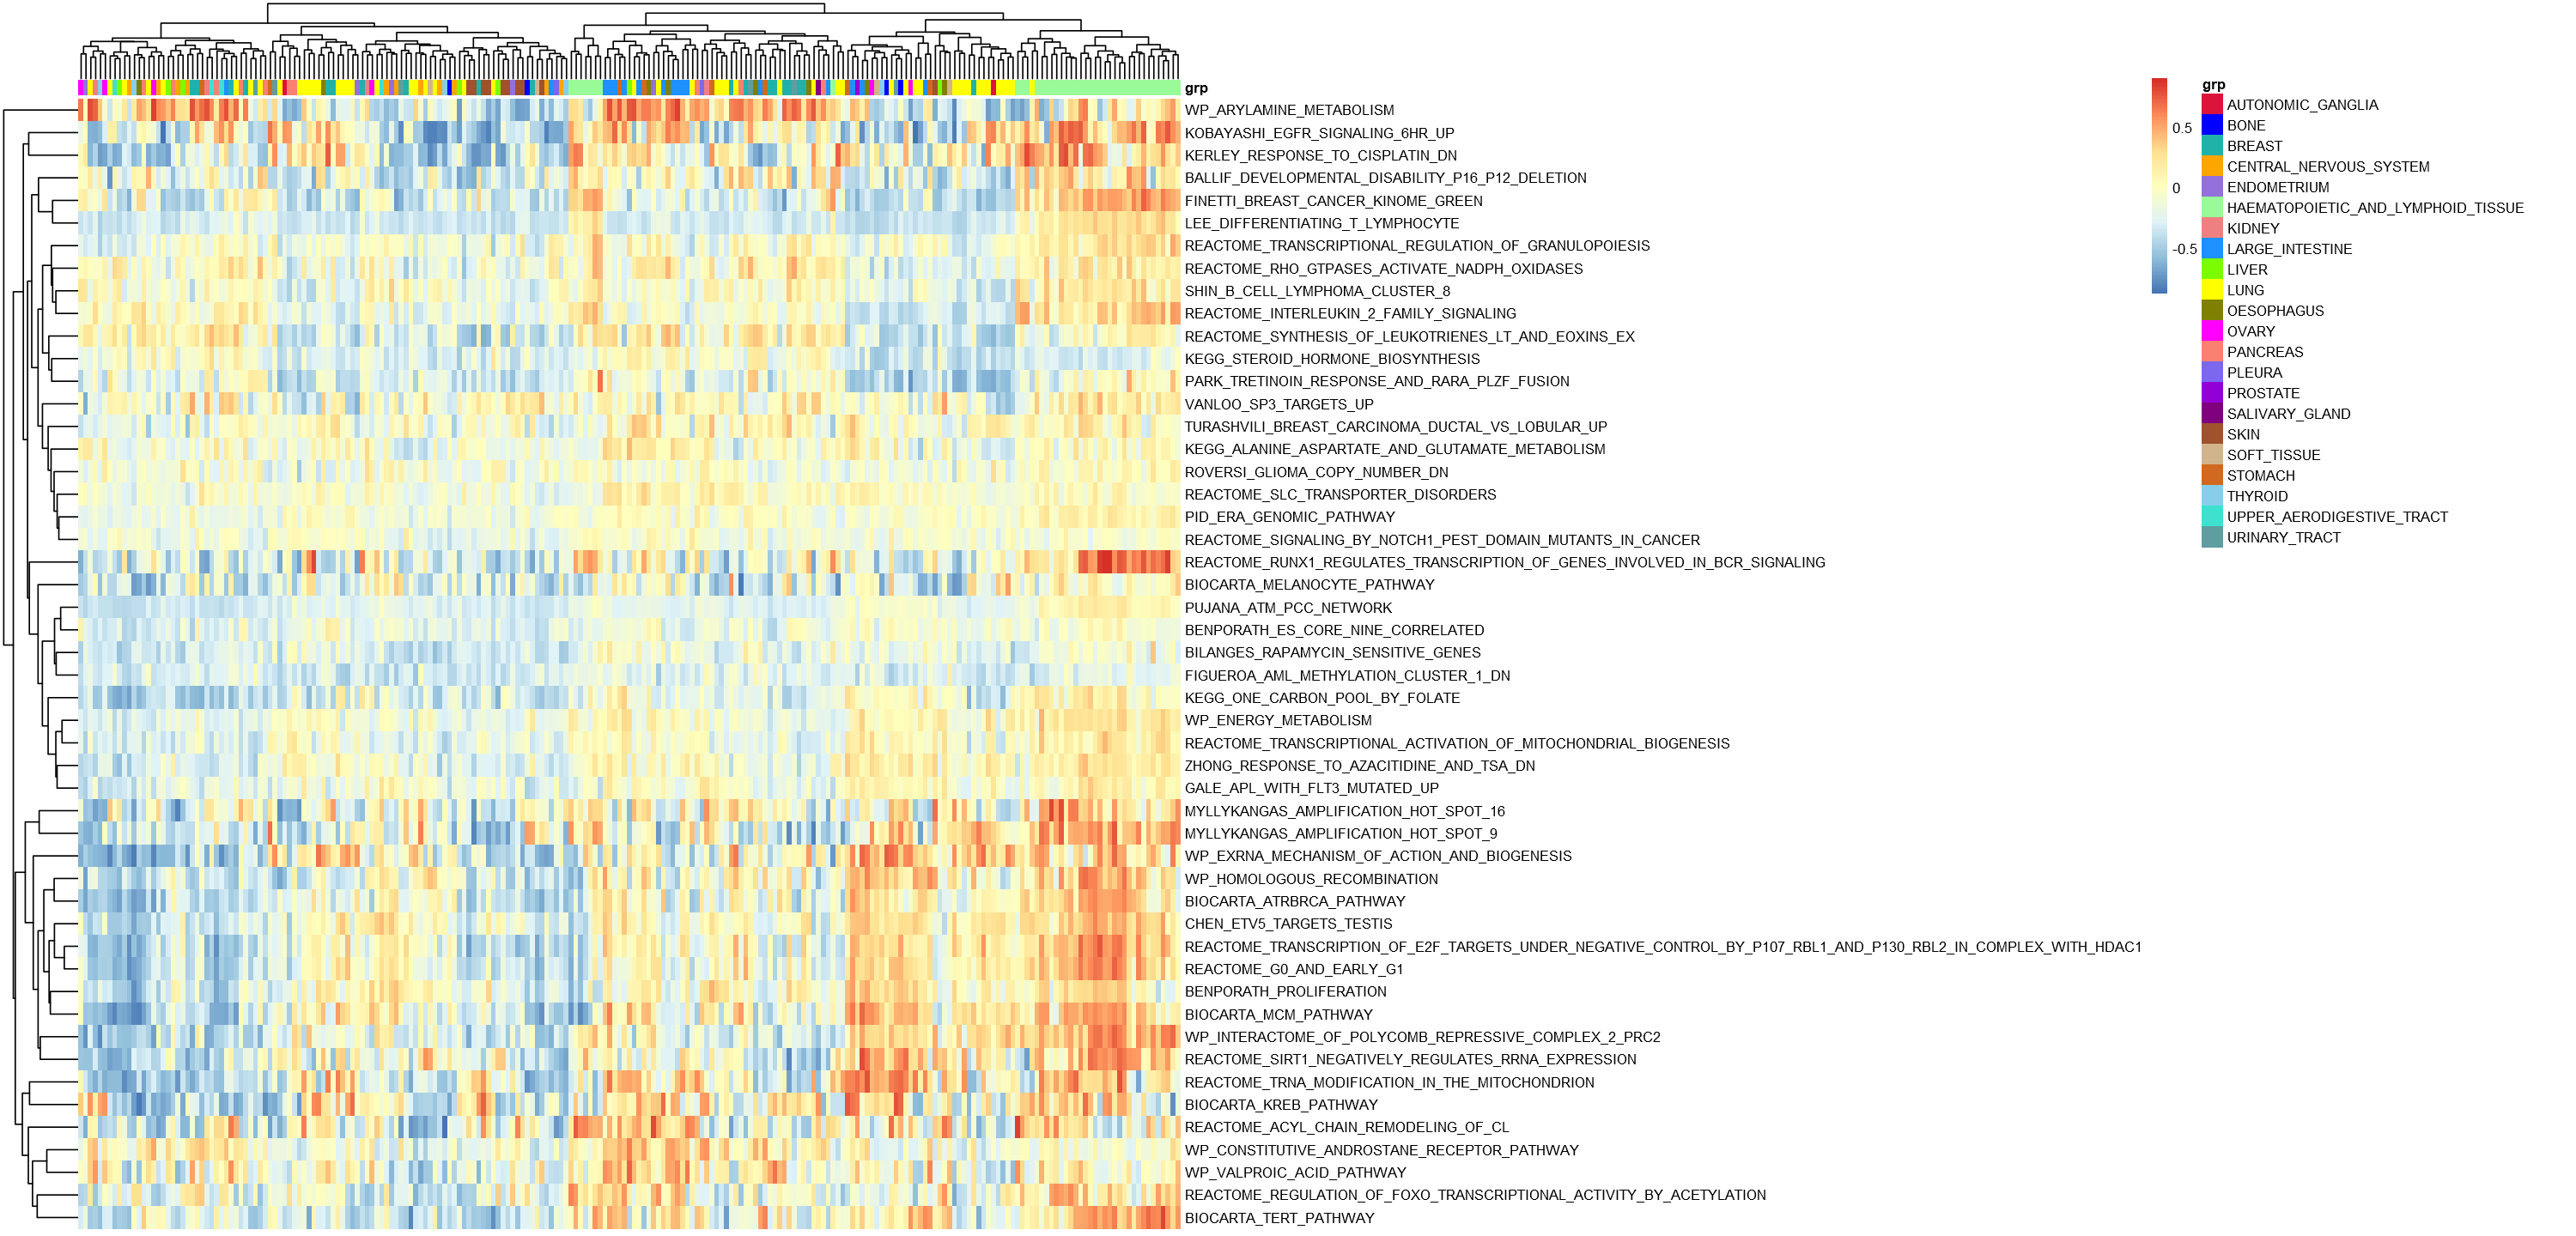

In [257]:
library(pheatmap)
options(repr.plot.width=25,repr.plot.height=12)
pheatmap(gsva_results_C2_filter_select_negative,
        show_rownames = T,
        show_colnames=F,
        #cellwidth=4,
        #cellheight=15,
        annotation_col=sampleInfo,
        annotation_colors=list(
        grp=color_select
        ),
        #filename="heatmap_negative_ibrutinib.pdf",
        scale="none")

In [259]:
pheatmap(gsva_results_C2_filter_select_negative,
        show_rownames = T,
        show_colnames=F,
        cellwidth=4,
        cellheight=15,
        annotation_col=sampleInfo,
        annotation_colors=list(
        grp=color_select
        ),
        filename="heatmap_negative_ibrutinib.pdf",
        scale="none")

###### Conclusions

这些通路越活越，对Ibrutinib的应答越好：

+ OBAYASHI_EGFR_SIGNALING_6HR_UP
+ RUNX1_REGULATES_TRANSCRIPTION_OF_GENES_INVOLVED_IN_BCR_SIGNALING

### 联合之前的耐药性数据进行分析

#### positive candidates

In [263]:
pdx_ibrutinib<-read.csv("gsva_results_C2_pdx.csv",row.names = 1)
head(pdx_ibrutinib)

,R21052988LR01,R21052989LR01,R21052990LR01,R21052991LR01,R21052992LR01,R21052993LR01,R21052995LR01,R21052996LR01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABBUD_LIF_SIGNALING_1_DN,0.3545766,-0.29135817,0.33784330,-0.16902114,-0.1098554,-0.30683108,-0.2038480,-0.007991501
ABBUD_LIF_SIGNALING_1_UP,0.2746336,0.22854627,-0.09001237,-0.36788533,-0.4894396,-0.04267121,0.0121725,0.283349755
ABBUD_LIF_SIGNALING_2_DN,0.4749922,-0.10696902,0.17074910,0.56818147,0.2098035,0.12107379,0.3476444,-0.678737524
ABBUD_LIF_SIGNALING_2_UP,-0.2963948,-0.09533516,-0.40768159,-0.02905719,0.2127959,-0.40710798,0.3579009,0.452045887
ABDELMOHSEN_ELAVL4_TARGETS,-0.2956641,-0.36141679,0.09989148,-0.14734725,0.2304432,0.21573980,-0.3134225,-0.092365563
ABDULRAHMAN_KIDNEY_CANCER_VHL_DN,0.1919341,0.40619816,0.05059339,-0.05284258,-0.1515515,-0.14380766,-0.5033455,-0.219024383


In [267]:
pdx_ibrutinib_positive=pdx_ibrutinib[positive_terms,]
dim(pdx_ibrutinib_positive)

[1] 42  8

In [271]:
pdxInfo=data.frame(group=c("vehicle","vehicle","vehicle",
                          "Parental","Parental","Parental",
                          "Resistance","Resistance"))
rownames(pdxInfo)=colnames(pdx_ibrutinib_positive)

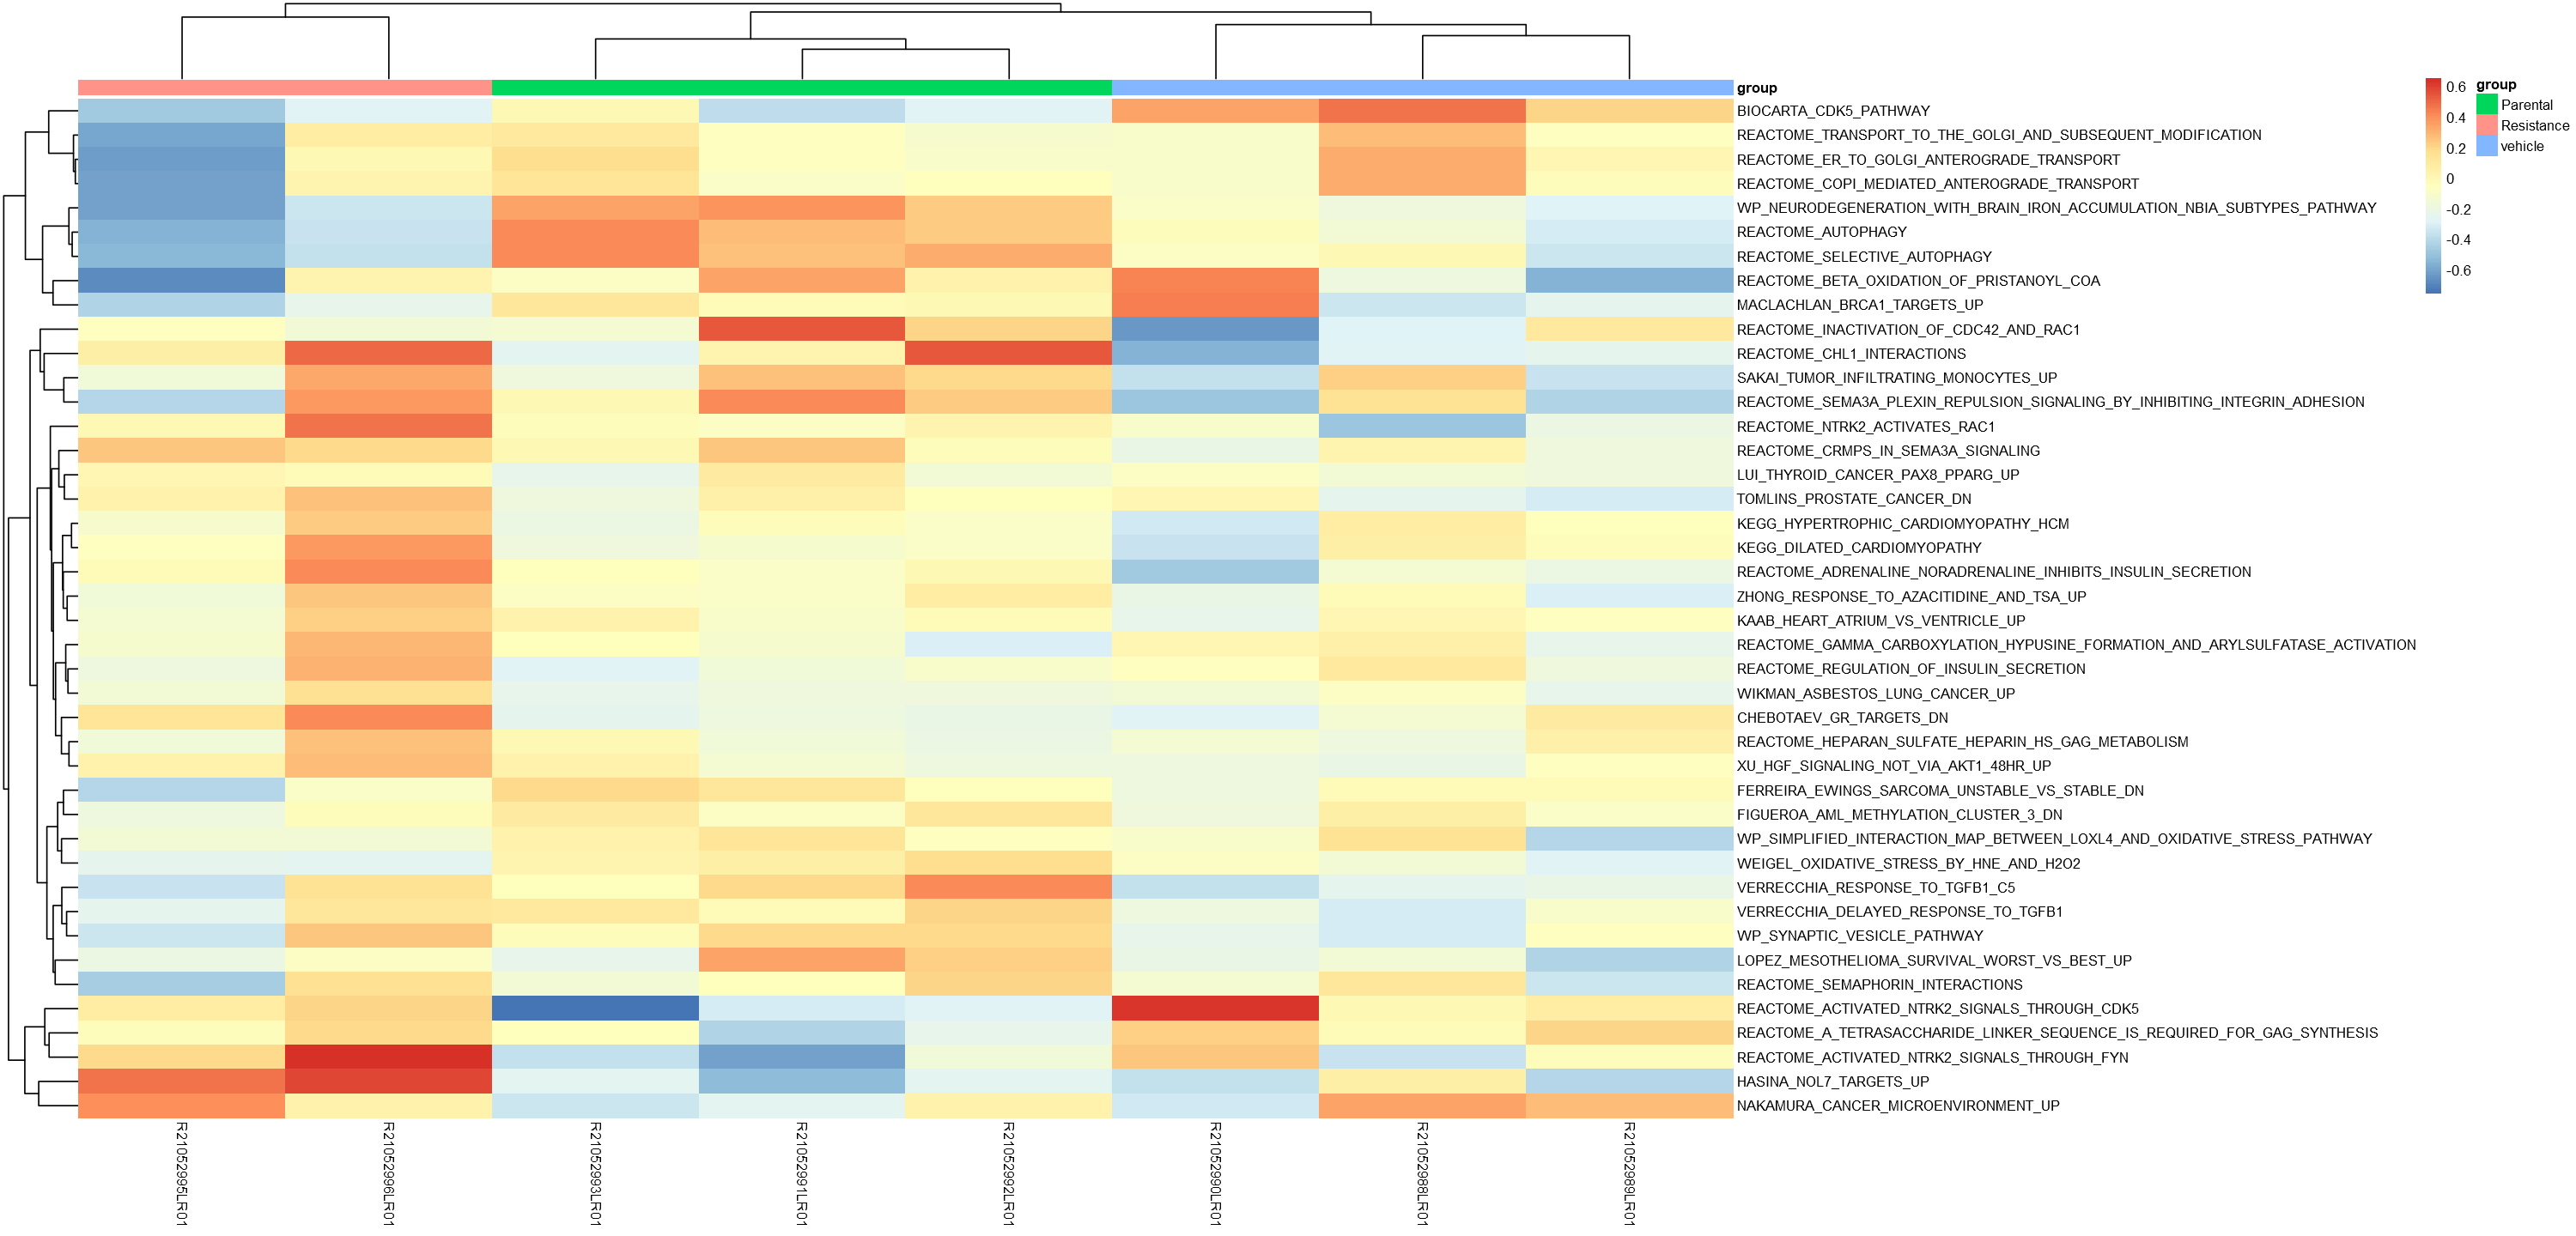

In [272]:
options(repr.plot.width=25,repr.plot.height=12)
pheatmap(pdx_ibrutinib_positive,
        show_rownames = T,
        show_colnames=T,
        annotation_col=pdxInfo,
        #cellwidth=4,
        #cellheight=15,
         #filename="heatmap_positive_ibrutinib.pdf",
        scale="none")

In [276]:
pheatmap(pdx_ibrutinib_positive,
        show_rownames = T,
        show_colnames=F,
        annotation_col=pdxInfo,
        cellwidth=30,
        cellheight=10,
         filename="heatmap_positive_ibrutinib_pdx.pdf",
        scale="none")

##### Conclusions

这些terms在 reistance组 相对较为活跃：

+ REACTOME_ACTIVATED_NTRK2_SIGNALS_THROUGH_CDK5
+ REACTOME_A_TETRASACCHARIDE_LINKER_SEQUENCE_IS_REQUIRED_FOR_GAG_SYNTHESIS
+ REACTOME_ACTIVATED_NTRK2_SIGNALS_THROUGH_FYN
+ <strong style="color:red">HASINA_NOL7_TARGETS_UP</strong>
+ NAKAMURA_CANCER_MICROENVIRONMENT_UP

#### Negative candidates

In [277]:
pdx_ibrutinib_negative=pdx_ibrutinib[negative_terms,]
dim(pdx_ibrutinib_negative)

[1] 50  8

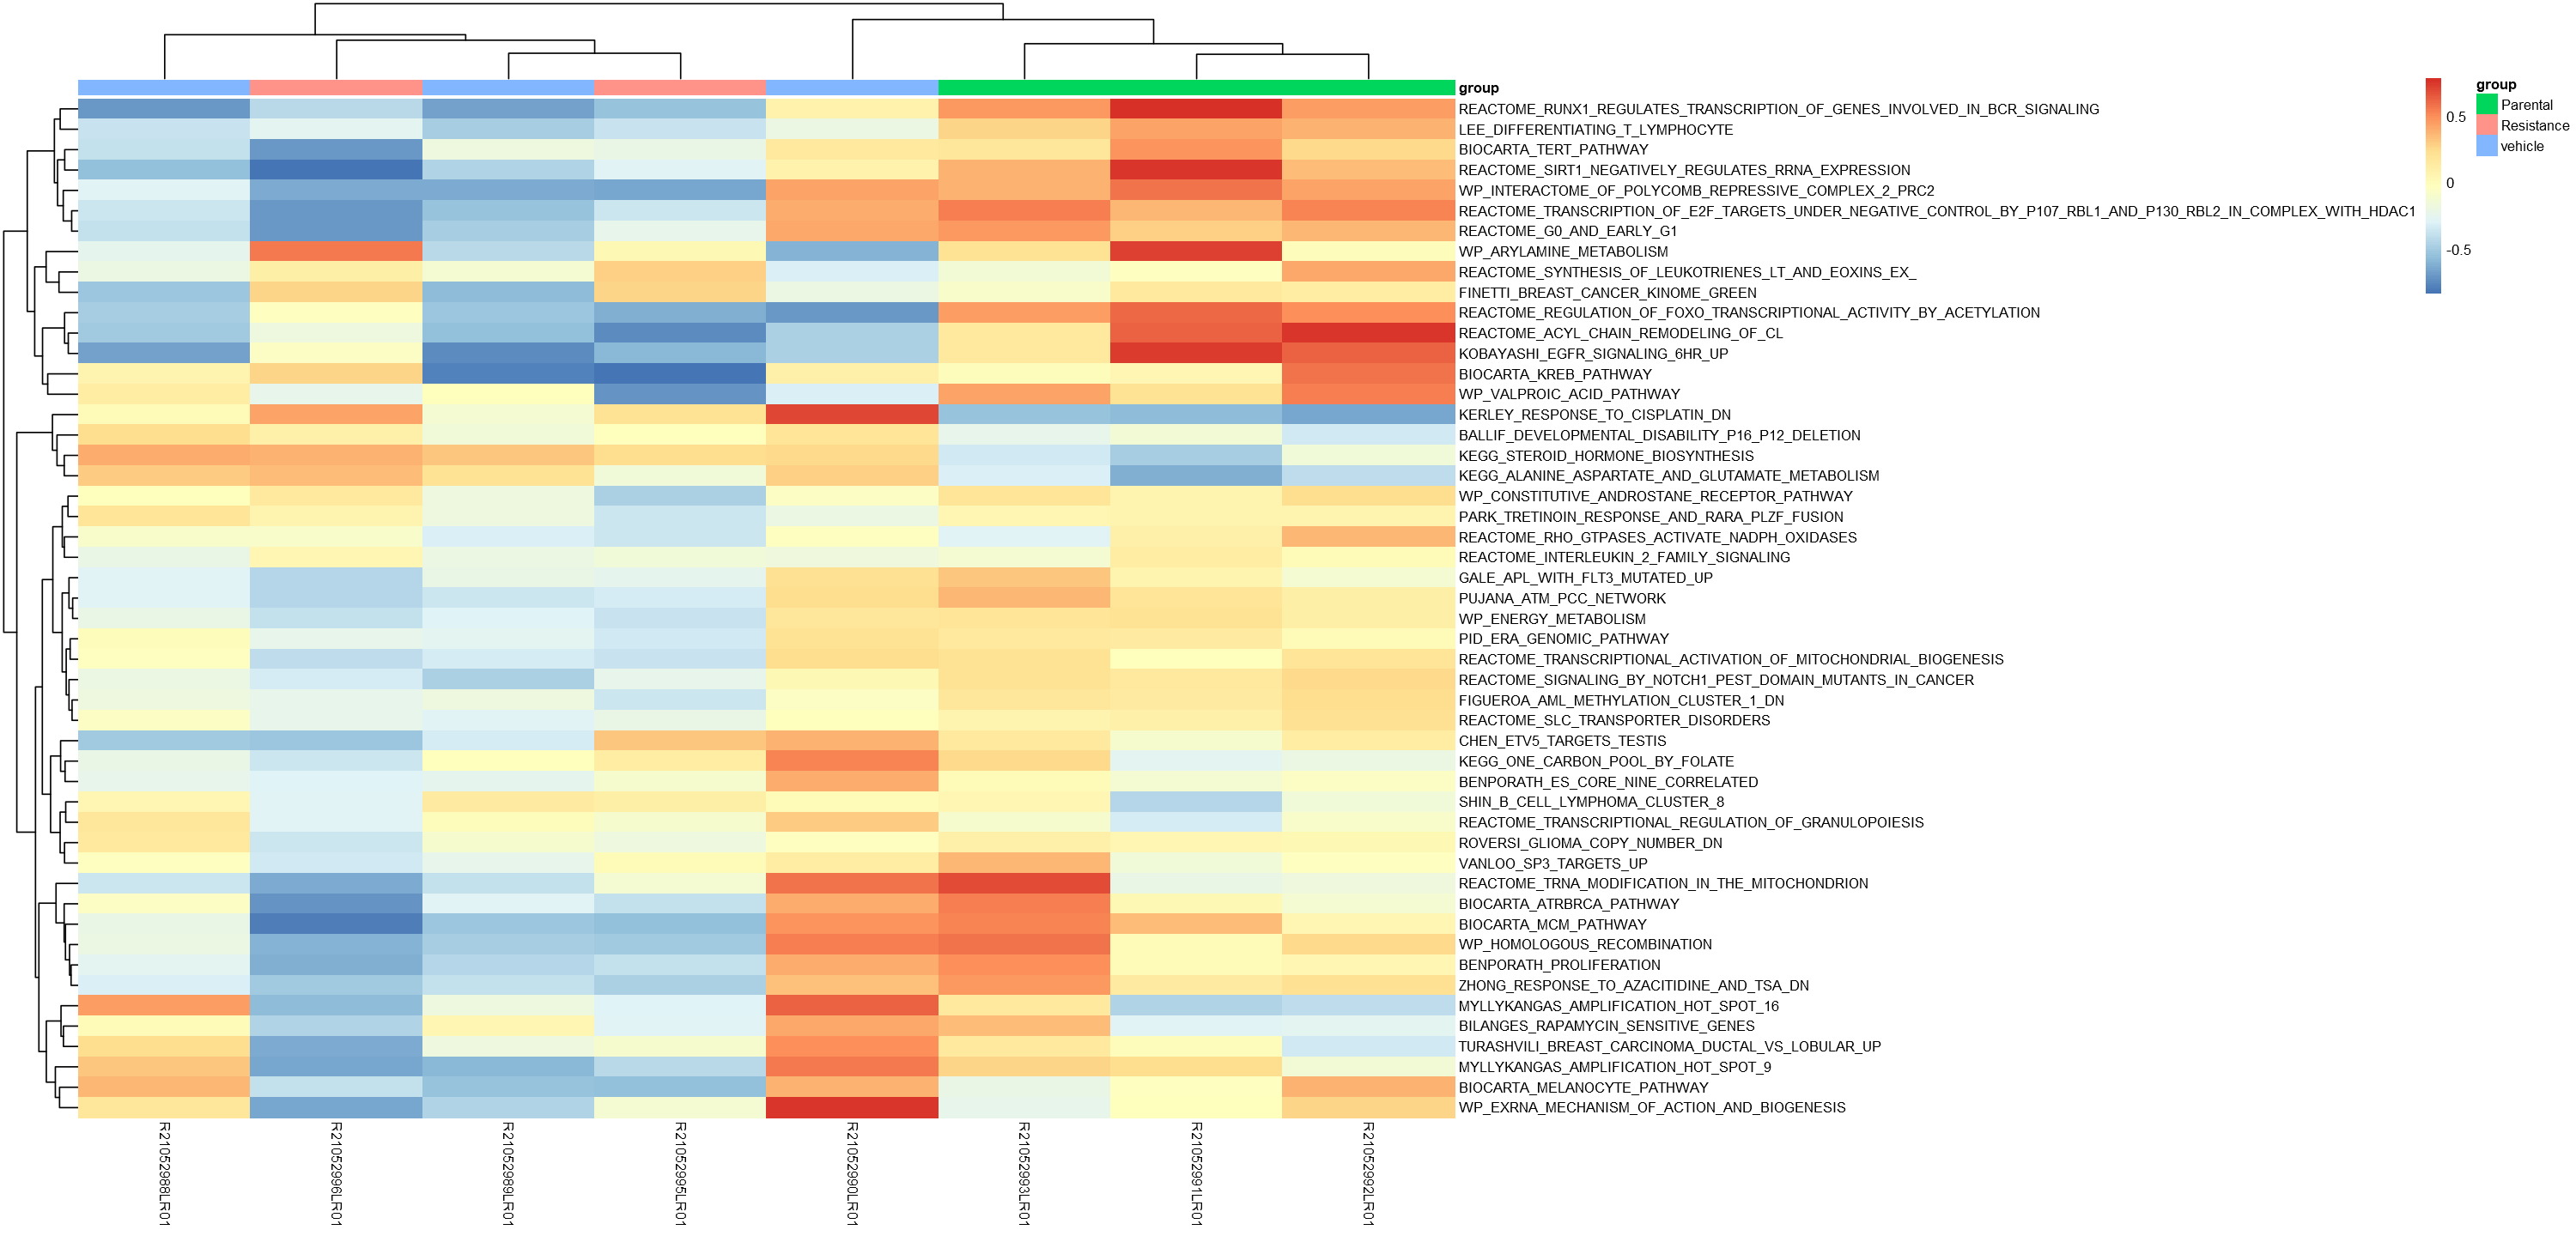

In [278]:
options(repr.plot.width=25,repr.plot.height=12)
pheatmap(pdx_ibrutinib_negative,
        show_rownames = T,
        show_colnames=T,
        annotation_col=pdxInfo,
        #cellwidth=4,
        #cellheight=15,
         #filename="heatmap_positive_ibrutinib.pdf",
        scale="none")

In [279]:
pheatmap(pdx_ibrutinib_negative,
        show_rownames = T,
        show_colnames=F,
        annotation_col=pdxInfo,
        cellwidth=30,
        cellheight=10,
         filename="heatmap_negative_ibrutinib_pdx.pdf",
        scale="none")

##### Conclusions

对于这些Negative candidates，值越高，对药物应答约敏感，尤其是一下terms：

+ REACTOME_RUNX1_REGULATES_TRANSCRIPTION_OF_GENES_INVOLVED_IN_BCR_SIGNALING
+ LEE_DIFFERENTIATING_T_LYMPHOCYTE
+ BIOCARTA_TERT_PATHWAY
+ REACTOME_SIRT1_NEGATIVELY_REGULATES_RRNA_EXPRESSION
+ WP_INTERACTOME_OF_POLYCOMB_REPRESSIVE_COMPLEX_2_PRC2
+ REACTOME_TRANSCRIPTION_OF_E2F_TARGETS_UNDER_NEGATIVE_CONTROL_BY_P107_RBL1_AND_P130_RBL2_IN_COMPLEX_WITH_HDAC1
+ REACTOME_G0_AND_EARLY_G1
+ WP_ARYLAMINE_METABOLISM

### Capmatinib 耐药分析

#### 选取Capmatinib 用药数据

In [260]:
GDSC_select_IC50<-read.csv("GDSC_select_IC50.csv",row.names = 1)
head(GDSC_select_IC50 )

,CELL_LINE_NAME,LN_IC50,DRUG_NAME,CCLNames
,<fct>,<dbl>,<fct>,<fct>
1,SK-ES-1,2.034050,Erlotinib,SKES1_BONE
2,COLO-829,2.966952,Erlotinib,COLO829_SKIN
3,8-MG-BA,2.494802,Erlotinib,8MGBA_CENTRAL_NERVOUS_SYSTEM
4,GB-1,3.604860,Erlotinib,GB1_CENTRAL_NERVOUS_SYSTEM
5,U-87-MG,3.877827,Erlotinib,U87MG_CENTRAL_NERVOUS_SYSTEM
6,NCI-H1648,-3.130514,Erlotinib,NCIH1648_LUNG


In [261]:
select_cells=GDSC_select_IC50  %>% filter(DRUG_NAME=="Capmatinib") %>% pull(CCLNames) %>% as.character
length(select_cells)

[1] 0

没有相关药物学实验